# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: x
- __Dataset__: The dataset represents claims from the start of 2020 till the end of 2022 (training data) and from January 2023 onward (test data). A detailed description of the columns of the datasets can be found below.
- __Task and Goal__: The purpose of this notebook is to create and evaluate several classification models for accurately predicting the WCB’s final decision on what type of injury should be given to a claim.

| **ATTRIBUTE**                        | **DESCRIPTION**                                                                                                         |
|--------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| Accident Date                        | Injury date of the claim.                                                                                               |
| Age at Injury                        | Age of injured worker when the injury occurred.                                                                         |
| Alternative Dispute Resolution       | Adjudication processes external to the Board.                                                                           |
| Assembly Date                        | The date the claim was first assembled.                                                                                 |
| Attorney/Representative              | Is the claim being represented by an Attorney?                                                                          |
| Average Weekly Wage                  | The wage used to calculate workers’ compensation, disability, or Paid Leave wage replacement benefits.                  |
| Birth Year                           | The reported year of birth of the injured worker.                                                                       |
| C-2 Date                             | Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).              |
| C-3 Date                             | Date Form C-3 (Employee Claim Form) was received.                                                                       |
| Carrier Name                         | Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker's employer. |
| Carrier Type                         | Type of primary insurance provider responsible for providing workers’ compensation coverage.                            |
| Claim Identifier                     | Unique identifier for each claim, assigned by WCB.                                                                      |
| County of Injury                     | Name of the New York County where the injury occurred.                                                                  |
| COVID-19 Indicator                   | Indication that the claim may be associated with COVID-19.                                                              |
| District Name                        | Name of the WCB district office that oversees claims for that region or area of the state.                              |
| First Hearing Date                   | Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held. |
| Gender                               | The reported gender of the injured worker.                                                                              |
| IME-4 Count                          | Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner’s Report of Independent Medical Examination” form. |
| Industry Code                        | NAICS code and descriptions are available at https://www.naics.com/search-naics-codes-by-industry/.                     |
| Industry Code Description            | 2-digit NAICS industry code description used to classify businesses according to their economic activity.               |
| Medical Fee Region                   | Approximate region where the injured worker would receive medical service.                                               |
| OIICS Nature of Injury Description   | The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.         |
| WCIO Cause of Injury Code            | The WCIO cause of injury codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.  |
| WCIO Cause of Injury Description     | See description of field above.                                                                                         |
| WCIO Nature of Injury Code           | The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.                     |
| WCIO Nature of Injury Description    | See description of field above.                                                                                         |
| WCIO Part Of Body Code               | The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.      |
| WCIO Part Of Body Description        | See description of field above.                                                                                         |
| Zip Code                             | The reported ZIP code of the injured worker’s home address.                                                             |
| Agreement Reached                    | Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.    |
| WCB Decision                         | Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim. |
| Claim Injury Type                    | Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.   |


## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the needed libraries

In [93]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the data and first overview

In [94]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)

In [95]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [96]:
test_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1
2,2022-12-26,59,N,2023-01-02,N,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,NaN,F,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0
3,2022-12-28,55,N,2023-01-02,N,0.0,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,6166047,QUEENS,N,NYC,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6
4,2022-12-20,25,N,2023-01-02,N,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,6166102,KINGS,N,NYC,NaN,M,NaN,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5


## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

In [97]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [98]:
# Have a first look at the numerical variables and their distirbutions
train_df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


In [99]:
# Have a first look at the categorical variables and their distirbutions
train_df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


In [100]:
# before working on the dataset, we will do a copy so we can use the original one if we need it
train_df_temp = train_df.copy()

## 2.1 __Target Variable__ Analysis

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [101]:
train_df_temp['Claim Injury Type'].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

In [102]:
non_comp_percent = round(train_df_temp['Claim Injury Type'].value_counts().max() / len(train_df_temp),4)

print('Percentage of Non-Comp Cases: {}%'.format(non_comp_percent*100))

Percentage of Non-Comp Cases: 49.05%


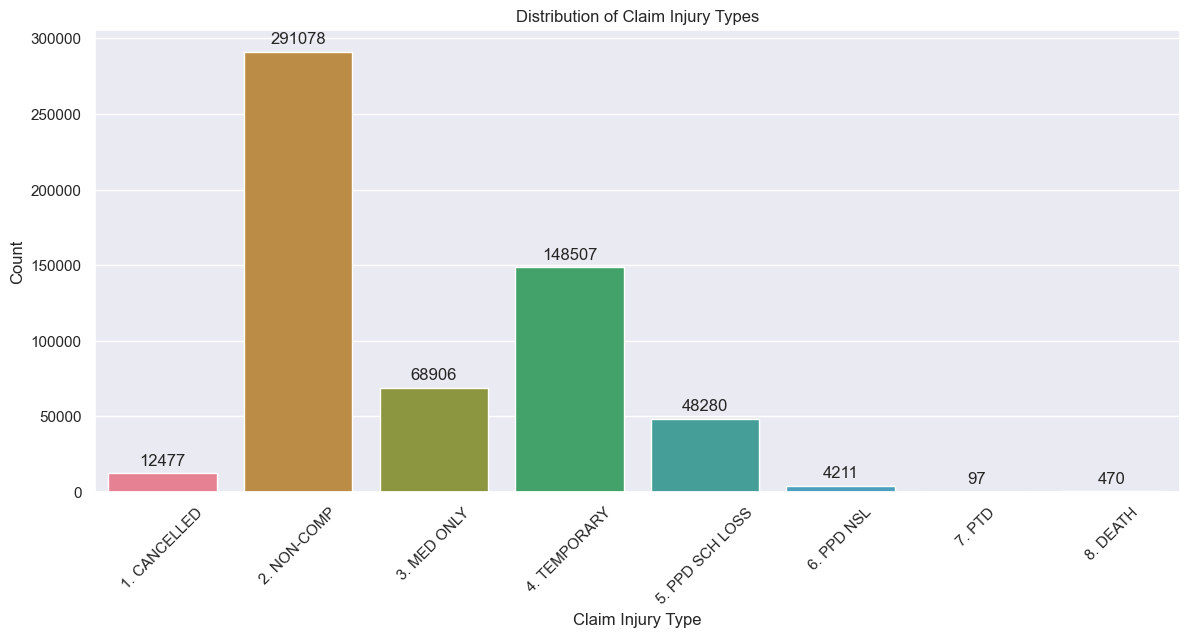

In [103]:
# Define the custom order for 'Claim Injury Type'
custom_order = ['1. CANCELLED', '2. NON-COMP', '3. MED ONLY', '4. TEMPORARY',
                '5. PPD SCH LOSS', '6. PPD NSL', '7. PTD', '8. DEATH']

# Plot distribution of target values with the custom order
target_values = train_df_temp['Claim Injury Type'].value_counts()

# Convert target values to a DataFrame and reorder based on custom order
df_target_counts = target_values.reset_index()
df_target_counts.columns = ['Claim Injury Type', 'Count']
df_target_counts = df_target_counts.set_index('Claim Injury Type').reindex(custom_order).reset_index()

plt.figure(figsize=(14, 6))
# Use a color palette to assign different colors to each bar
palette = sns.color_palette("husl", len(df_target_counts))
barplot = sns.barplot(x='Claim Injury Type', y='Count', data=df_target_counts, palette=palette, order=custom_order)

# Annotate the counts on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.title('Distribution of Claim Injury Types')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have 7 different classes. One class, "NON-COMP", is very dominantly present with making up for 49.05% of the cases.

Let's have an initial look at the spearman correlation of the target variable with the other features: 

We use spearman correlation because we suspect that the relationship between our variables and target is non-linear, and also because our data contains outliers that can distort the analysis. Also, our data violate the assumptions of linearity and don't follow a normal distribtuion so spearman correlation is more adequate here. Also, despite the fact that our data is not ordinal we decide it to visualize its distribution in an ordinal way because we know that from 1 to 8 , it's the scale of the severity of the injury , and thus the compensations are ordered in severity order.

Spearman Correlations with 'Claim Injury Type Numeric':
Claim Injury Type Numeric             1.000000
Average Weekly Wage                   0.855234
Agreement Reached                     0.235905
Age at Injury                         0.118533
Industry Code                         0.028782
WCIO Nature of Injury Code            0.023586
WCIO Part Of Body Code                0.000096
Number of Dependents                 -0.000625
IME-4 Count                          -0.007009
WCIO Cause of Injury Code            -0.039392
Birth Year                           -0.084158
Claim Identifier                     -0.154982
OIICS Nature of Injury Description         NaN
Name: Claim Injury Type Numeric, dtype: float64


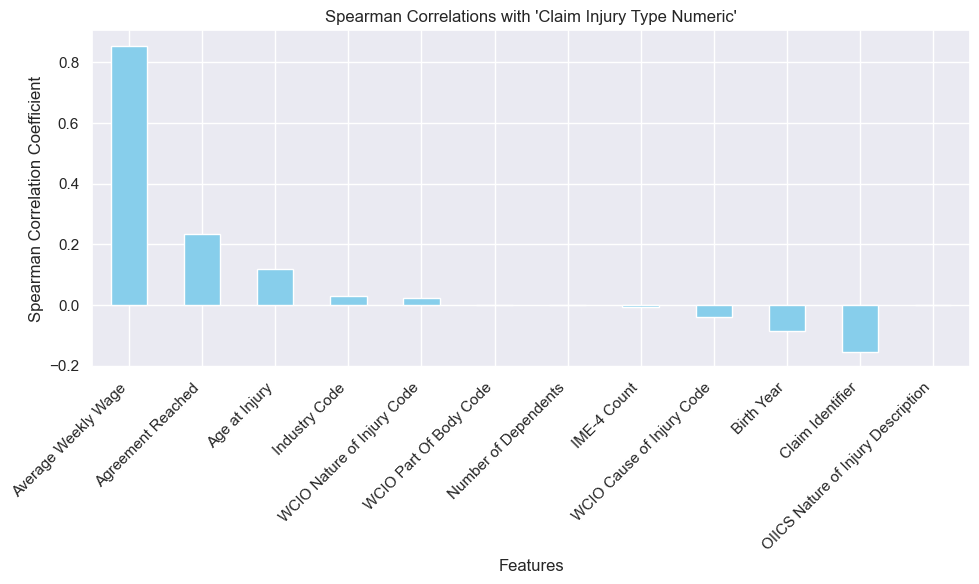

In [104]:
# Convert 'Claim Injury Type' to numeric if not already done
train_df_temp['Claim Injury Type Numeric'] = train_df_temp['Claim Injury Type'].astype('category').cat.codes

# Select only numeric columns
numeric_cols = train_df_temp.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
spearman_corr = numeric_cols.corr(method='spearman')

# Display correlations with the target variable 'Claim Injury Type Numeric'
target_correlations = spearman_corr['Claim Injury Type Numeric'].sort_values(ascending=False)

# Print the correlations
print("Spearman Correlations with 'Claim Injury Type Numeric':")
print(target_correlations)

# Plot the correlations as a bar chart for better visualization
plt.figure(figsize=(10, 6))
target_correlations.drop('Claim Injury Type Numeric').plot(kind='bar', color='skyblue')
plt.title("Spearman Correlations with 'Claim Injury Type Numeric'")
plt.ylabel("Spearman Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1. Strongest correlations: 

Average Weekly Wage has the highest positive correlation with the target (0.855), suggesting that there may be a strong monotonic relationship between the weekly wage and the type of claim injury.

2. Moderate Correlations:

Agreement Reached shows a moderate positive correlation (0.236), indicating that cases where an agreement was reached may be related to specific types of claim injuries.

Age at Injury has a weaker positive correlation (0.119), implying a slight relationship between age and the type of claim injury.

3. Minimal correlations:

Industry Code, WCIO Nature of Injury Code, WCIO Part Of Body Code, and Number of Dependents , Claim Identifier and Birth Year , WCIO Cause of Injury Code

So lets have a look at the features itself.

__Age at Injury__

In [105]:
train_df_temp['Age at Injury'].describe()

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64

We can already see that the minimum and maximum values seem kind of strang with ranging from 0 to 117. We will deal with them in the outlier section.

In [106]:
# plot the distribution of a single feature with respect to the target categorical variable.
def feature_distribution(data, feature, target_variable):
    plt.figure(figsize=(13, 8))
    sns.histplot(data=data, x=feature, hue=target_variable, multiple="stack")
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


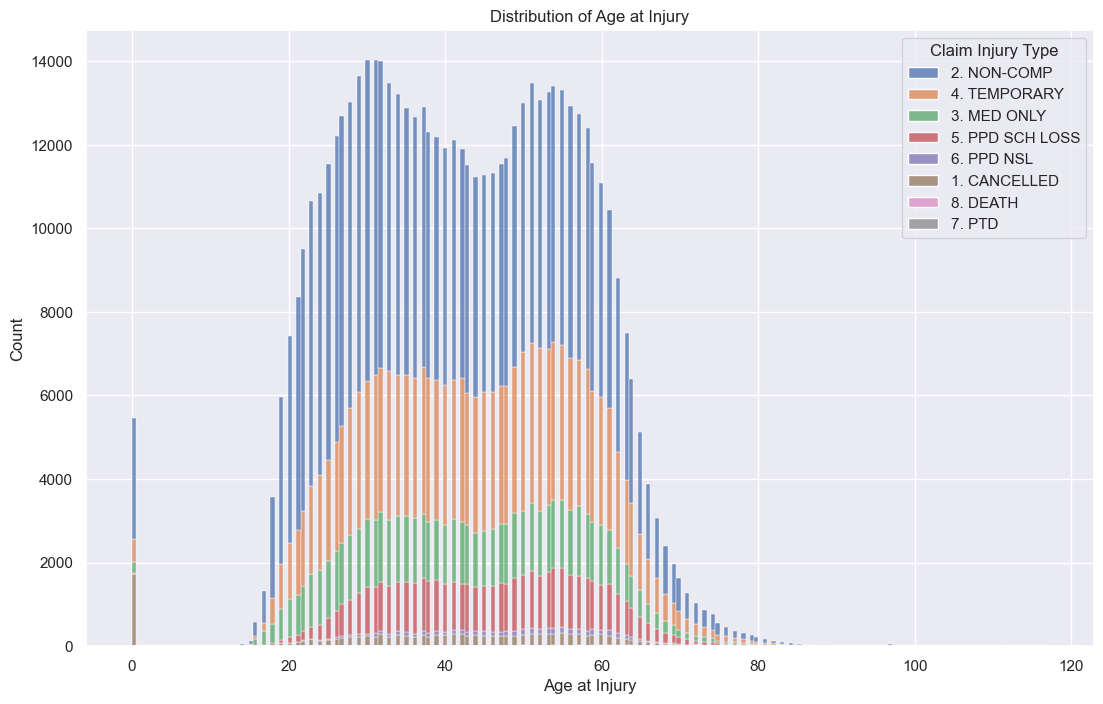

In [107]:
feature_distribution(train_df_temp, 'Age at Injury', 'Claim Injury Type')

Some conclusions on the distribution of the claim injury type related to the age can already be seen:

1. The 2. NON-COMP claim type is the most prevalent across all age groups, indicating that non-compensable cases are frequent regardless of age

2. The distribution is most concentrated between the ages of approximately 20 and 60, suggesting that most injury claims occur within the working-age population.

3. The number of claims decreases significantly for ages above 60 and below 20, indicating fewer injury claims for younger and older individuals

4. The 8. DEATH and 7. PTD (permanent total disability) claim types appear infrequently, showing they are relatively rare outcomes.

5. There is a noticeable spike in 2. NON-COMP claims for very young ages (below 20), which might indicate special cases, data anomalies, or claims related to youth employment or specific circumstances.


## 2.2 Data __Anomalies__ and __Inconsistencies__

Missing values analysis

In [108]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(train_df_temp)

Your selected dataframe has 34 columns.
There are 31 columns that have missing values.


In [109]:
missing_values.head(15)

,Missing Values,% of Total Values
OIICS Nature of Injury Description,593471,100.0
IME-4 Count,460668,77.6
First Hearing Date,442673,74.6
C-3 Date,406226,68.4
Birth Year,48523,8.2
Average Weekly Wage,48096,8.1
Zip Code,48082,8.1
WCIO Part Of Body Description,36527,6.2
WCIO Part Of Body Code,36527,6.2
WCIO Nature of Injury Description,35102,5.9


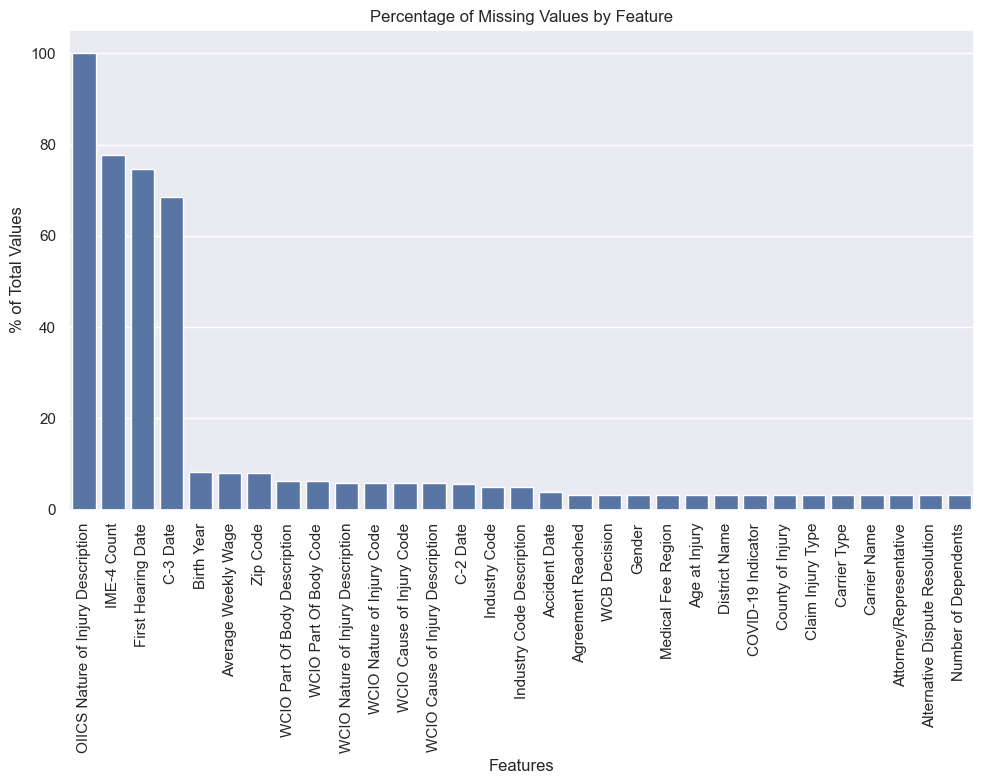

In [110]:
def plot_missing_values(mis_val_table, title):
    plt.figure(figsize=(10, 8))
    
    # Create a bar plot for the percentage of missing values
    sns.barplot(x=mis_val_table.index, 
                y=mis_val_table['% of Total Values'])
    
    # Rotate the x labels for better readability
    plt.xticks(rotation=90)
    
    # Set plot labels and title
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('% of Total Values')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the missing values
plot_missing_values(missing_values,title= 'Percentage of Missing Values by Feature')

These colums are the ones that have lots of missing values so we'll have to address them in the later section of pre-processing and data cleaning.

* OIICS Nature of Injury Description:		100.0 % 

* IME-4 Count:		77.6%

* First Hearing Date:	74.6%

* C-3 Date:		68.4% 

Null values analysis

In [111]:
# Function to calculate zero values by column
def zero_values_table(df):
    # Total zero values
    zero_val = (df == 0).sum()
    
    # Percentage of zero values
    zero_val_percent = 100 * (df == 0).sum() / len(df)
    
    # Make a table with the results
    zero_val_table = pd.concat([zero_val, zero_val_percent], axis=1)
    
    # Rename the columns
    zero_val_table_ren_columns = zero_val_table.rename(
        columns={0: 'Zero Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of zero values in descending order
    zero_val_table_ren_columns = zero_val_table_ren_columns[
        zero_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    # Print summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
          "There are " + str(zero_val_table_ren_columns.shape[0]) +
          " columns that have zero values.")
    
    # Return the dataframe with zero values information
    return zero_val_table_ren_columns


zero_values = zero_values_table(train_df_temp)

Your selected dataframe has 34 columns.
There are 6 columns that have zero values.


In [112]:
zero_values.head(15)

# The column Agreement Date has a high percentage of zero values because it's a binary feature and thus being equal to 0 means no Agreement Reached.

,Zero Values,% of Total Values
Agreement Reached,547239,92.2
Average Weekly Wage,335450,56.5
Number of Dependents,81665,13.8
Birth Year,25081,4.2
Claim Injury Type Numeric,12477,2.1
Age at Injury,5464,0.9


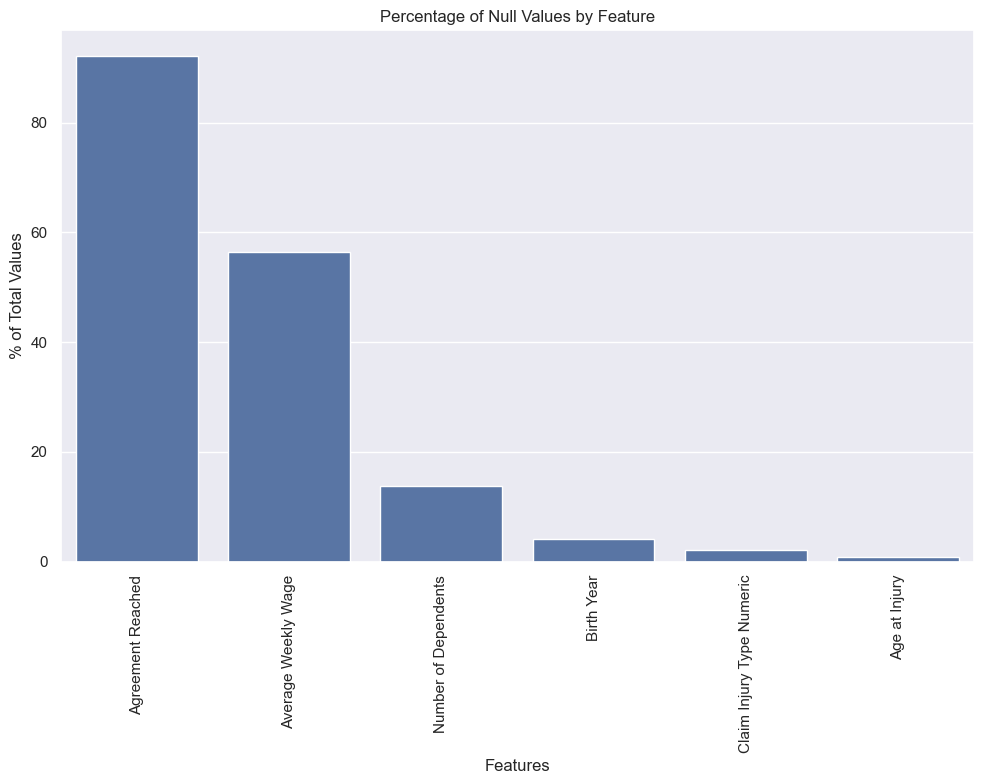

In [113]:
plot_missing_values(zero_values,title='Percentage of Null Values by Feature')

These colums are the ones that have lots of null values so we'll have to address them in the later section of pre-processing and data cleaning.

* (The column Agreement Date has a high percentage of zero values because it's a binary feature and thus being equal to 0 means no Agreement Reached)

* Average Weekly Wage:	56.5 % 

* Number of Dependents:	13.8% 

Individual Feature Analysis

In [114]:
# First, split the features into numerical and categorical

# Select numerical columns
numerical_cols = train_df_temp.select_dtypes(include=[np.number])

# Select categorical columns
categorical_cols = train_df_temp.select_dtypes(include=[object])

In [115]:
def numerical_describe(df, numerical_col):
    # Check if the column in the DataFrame is numerical
    if np.issubdtype(df[numerical_col].dtype, np.number):
        return df[numerical_col].describe()
    else:
        return None

# Iterate over the list of numerical columns
for col in numerical_cols:
    print(f"Description for column {col}:\n")
    description = numerical_describe(train_df_temp, col)
    if description is not None:
        print(description)
    else:
        print(f"Column {col} is not numerical.\n")

Description for column Age at Injury:

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Description for column Average Weekly Wage:

count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Description for column Birth Year:

count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Description for column Claim Identifier:

count    5.934710e+05
mean     2.366760e+07
std      1.079271e+08
min      5.393066e+06
25%      5.593414e+06
50%      5.791212e+06
75%      5.991000e+06
max      9.998917e+08
Name: C

### Summary from Individual Feature Analysis:

#### Key Points:

- **Age at Injury**: Min = 0 (missing/incorrect data), Max = 117 (possible outlier).
- **Average Weekly Wage**: Min = 0 (unreported/missing), Max = 2,828,079 (extreme outlier; 75th percentile = 841).
- **Birth Year**: Min = 0 (erroneous), Max = 2018 (unrealistic), Mean = 1886.77 (outliers likely).
- **Claim Identifier**: High variability, broad range, potentially expected as an identifier.
- **IME-4 Count**: Max = 73, indicating outliers beyond the 75th percentile of 4.
- **OIICS Nature of Injury**: Missing entirely; may need imputation/removal.
- **WCIO Part Of Body Code**: Min = -9 (data error).
- **Agreement Reached**: Mean = 4.67% of cases; shows class imbalance.
- **Number of Dependents**: Max = 6 (reasonable, needs context verification).
- **Claim Injury Type Numeric**: Min = -1 (error), 75th percentile = 3, Max = 7 (varied types, needs review).








In [116]:
def categorical_describe(df, categorical_col):
    # Check if the column in the DataFrame is categorical
    if df[categorical_col].dtype == 'object' or df[categorical_col].dtype.name == 'category':
        description = df[categorical_col].describe()
        return description
    else:
        return None

# Iterate over the list of categorical columns
for col in categorical_cols:
    print(f"Description for column {col}:\n")
    description = categorical_describe(train_df_temp, col)
    if description is not None:
        print(description)
    else:
        print(f"Column {col} is not categorical.\n")

Description for column Accident Date:

count         570337
unique          5539
top       2020-03-01
freq            1245
Name: Accident Date, dtype: object
Description for column Alternative Dispute Resolution:

count     574026
unique         3
top            N
freq      571412
Name: Alternative Dispute Resolution, dtype: object
Description for column Assembly Date:

count         593471
unique          1096
top       2020-03-06
freq            1422
Name: Assembly Date, dtype: object
Description for column Attorney/Representative:

count     574026
unique         2
top            N
freq      392291
Name: Attorney/Representative, dtype: object
Description for column C-2 Date:

count         559466
unique          2475
top       2021-05-11
freq            1847
Name: C-2 Date, dtype: object
Description for column C-3 Date:

count         187245
unique          1648
top       2021-04-21
freq             350
Name: C-3 Date, dtype: object
Description for column Carrier Name:

count       

### Summary from Individual Categorical Feature Analysis:

#### Key Points from Categorical Analysis:

- **Accident Date**: High count (570,337) and variety (5,539 unique dates), with the most frequent date being 2020-03-01 (1,245 times).

- **Alternative Dispute Resolution**: Predominantly 'N' (571,412 out of 574,026), indicating limited use of this option.

- **Assembly Date**: Complete data (593,471), with 1,096 unique dates. Most frequent date: 2020-03-06 (1,422 times).

- **Attorney/Representative**: Majority response is 'N' (392,291 out of 574,026), showing fewer cases with attorney involvement.

- **C-2 Date**: Well-populated (559,466) with 2,475 unique values. Top date: 2021-05-11 (1,847 times).

- **C-3 Date**: Lower count (187,245), indicating many missing values. Top date: 2021-04-21 (350 times).

- **Carrier Name**: Complete data (574,026) with high diversity (2,046 unique). Most frequent: STATE INSURANCE FUND (111,144 times).

- **Carrier Type**: Predominantly '1A. PRIVATE' (285,368 out of 574,026).

- **Claim Injury Type**: Common type is '2. NON-COMP' (291,078 times).

- **County of Injury**: Widely varied (63 unique), with Suffolk being the most common (60,430 times).

- **COVID-19 Indicator**: Predominantly 'N' (546,505 out of 574,026).

- **District Name**: Most cases handled in NYC (270,779 times).

- **First Hearing Date**: Lower count (150,798) with varied dates. Top date: 2022-04-15 (440 times).

- **Gender**: Majority male (335,218 out of 574,026).

- **Industry Code Description**: Common in 'HEALTH CARE AND SOCIAL ASSISTANCE' (114,339 times).

- **Medical Fee Region**: Dominated by Region IV (265,981 times).

- **WCIO Cause of Injury Description**: Most common cause: 'LIFTING' (46,610 times).

- **WCIO Nature of Injury Description**: Predominantly 'STRAIN OR TEAR' (153,373 times).

- **WCIO Part Of Body Description**: Most common part affected is 'LOWER BACK AREA' (51,862 times).

- **Zip Code**: High diversity (10,060 unique). Most frequent: 11236 (3,302 times).

- **WCB Decision**: Uniform value ('Not Work Related') across all records (574,026 times).


#### Visual Data Analysis for Numerical Features after describing them

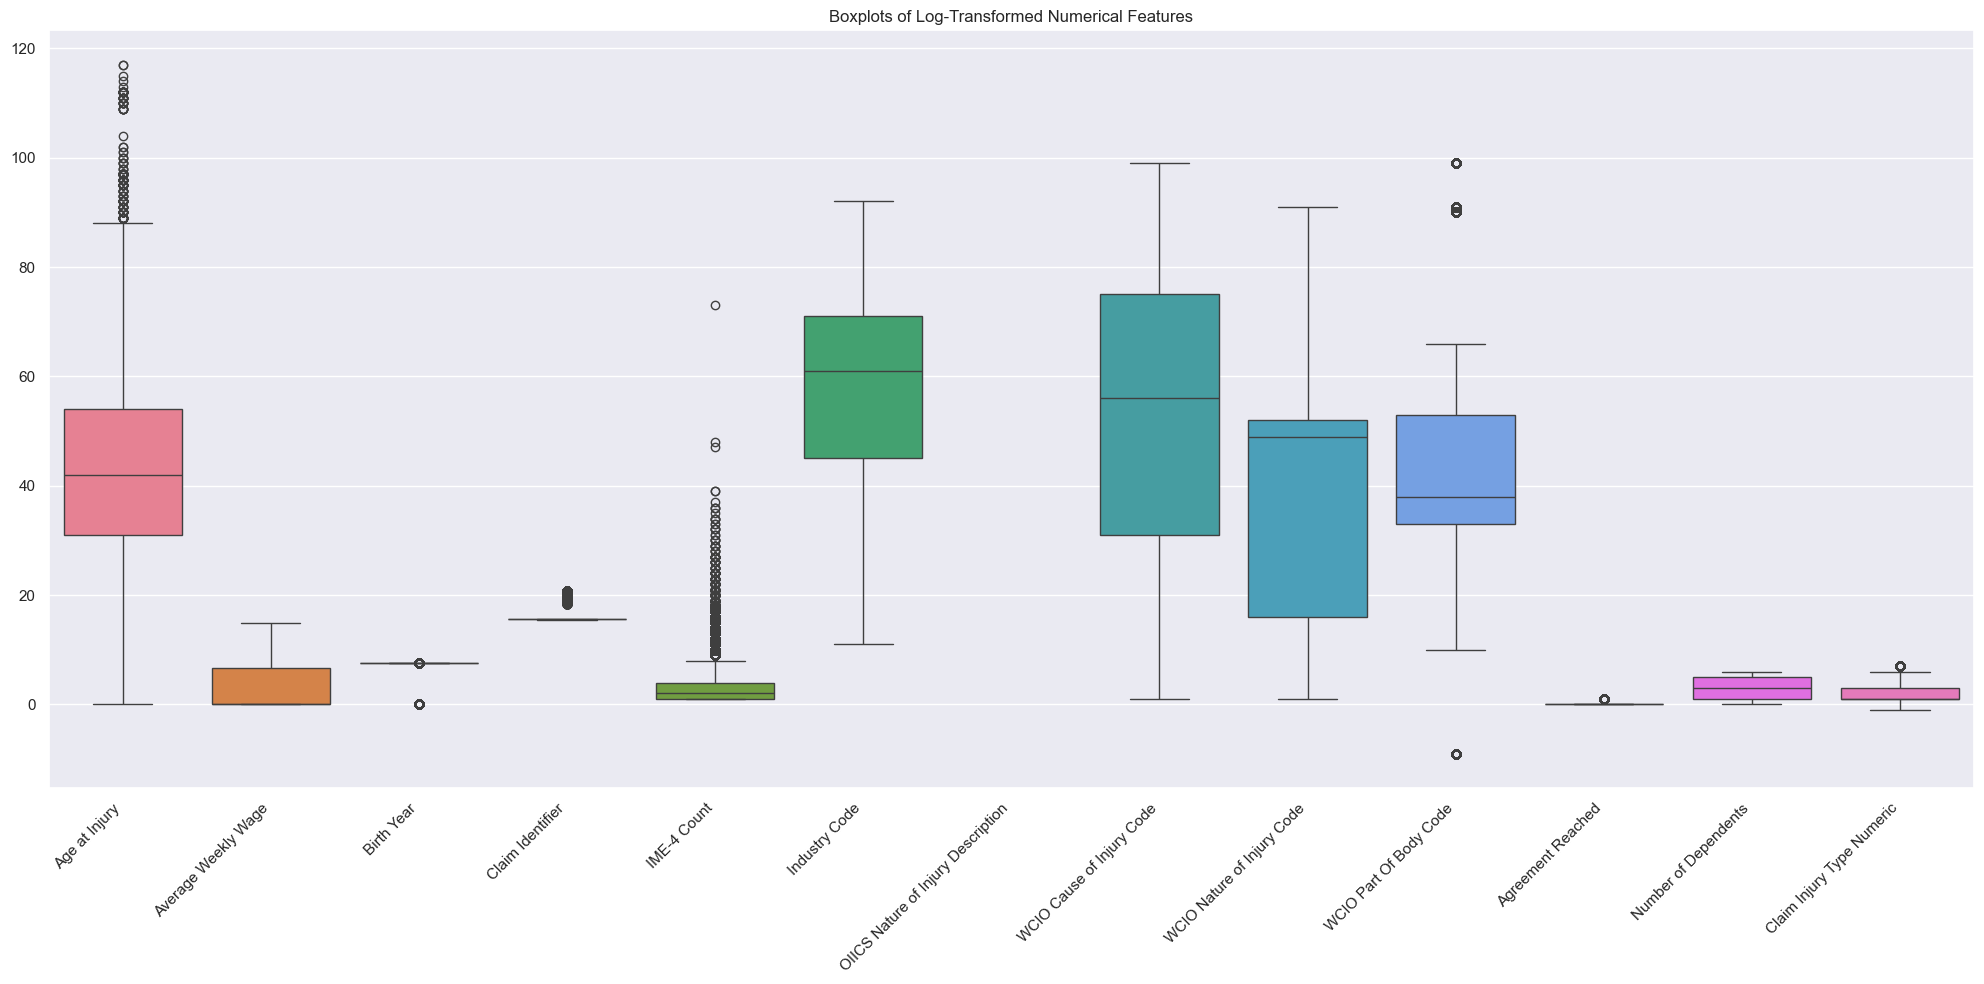

In [117]:
# Plot boxplots for all numerical features in a compact manner
num_cols_count = len(numeric_cols.columns)

# Apply log transformation to variables with extreme scales to improve visualization
numeric_cols_log = numeric_cols.copy()
for col in numeric_cols_log.columns:
    if numeric_cols_log[col].max() > 1000:  # Apply to columns with high values
        numeric_cols_log[col] = np.log1p(numeric_cols_log[col])  # log1p to handle zero values safely

# Plot boxplots for the log-transformed numerical features
plt.figure(figsize=(20, 10))  # Adjust size for better readability
sns.boxplot(data=numeric_cols_log)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplots of Log-Transformed Numerical Features')
plt.tight_layout()
plt.show()

### Observations from Boxplots of Log-Transformed Numerical Features:

1. **Age at Injury**:
   - Wide spread with outliers extending past 100, indicating variability in the data and potential outliers at older ages.

2. **Average Weekly Wage**:
   - Compact distribution with some outliers. Also, > 50% of the values are 0 so we'll have to take that into account


3. **Birth Year**:
   - Narrow range with a few outliers, which could indicate data entry errors or edge cases (e.g., very low or high years).

4. **Claim Identifier**:
   - Tight distribution, suggesting it is likely an ID rather than a useful variable for analysis. Outliers could represent different data entry segments.

5. **IME-4 Count**:
   - Many outliers present, indicating that while most counts are low, there are some significantly higher values.

6. **Industry Code**:
   - Relatively even distribution with few outliers, suggesting a spread across different codes.

7. **WCIO Codes (Cause, Nature, Part of Body)**:
   - Moderate spread with some outliers, indicating variability in reported injury data.

8. **Agreement Reached**:
   - Minimal spread, confirming that it is a binary var. or, with only a few outliers.

9. **Number of Dependents**:
   - Narrow range with a few outliers, indicating most values cluster tightly with some higher counts.

10. **Claim Injury Type Numeric (Target Var.)**:
    - Tight distribution with a few outliers, indicating that most data points fall within a small range but some deviations exist.
    - Given the class distribution analysis shown in the bar chart, it's clear that most instances are concentrated in a few categories, which aligns with the narrow spread observed in the boxplot.
    - The presence of outliers could represent rarer claim types, which may be difficult for models to predict due to limited examples in these categories.


#### Individual Analysis in Numerical Features

__Birth Year__

This variable results from accident date and age at accident. Therefore, we do not need it as it does not add any new information.

In [118]:
train_df_temp = train_df_temp.drop(columns='Birth Year')

Analysis in the numerical variables that left (Age at Injury, Avg. Weekly Wage, Claim identifier, IME-4 Count, Nr. of Dependents)

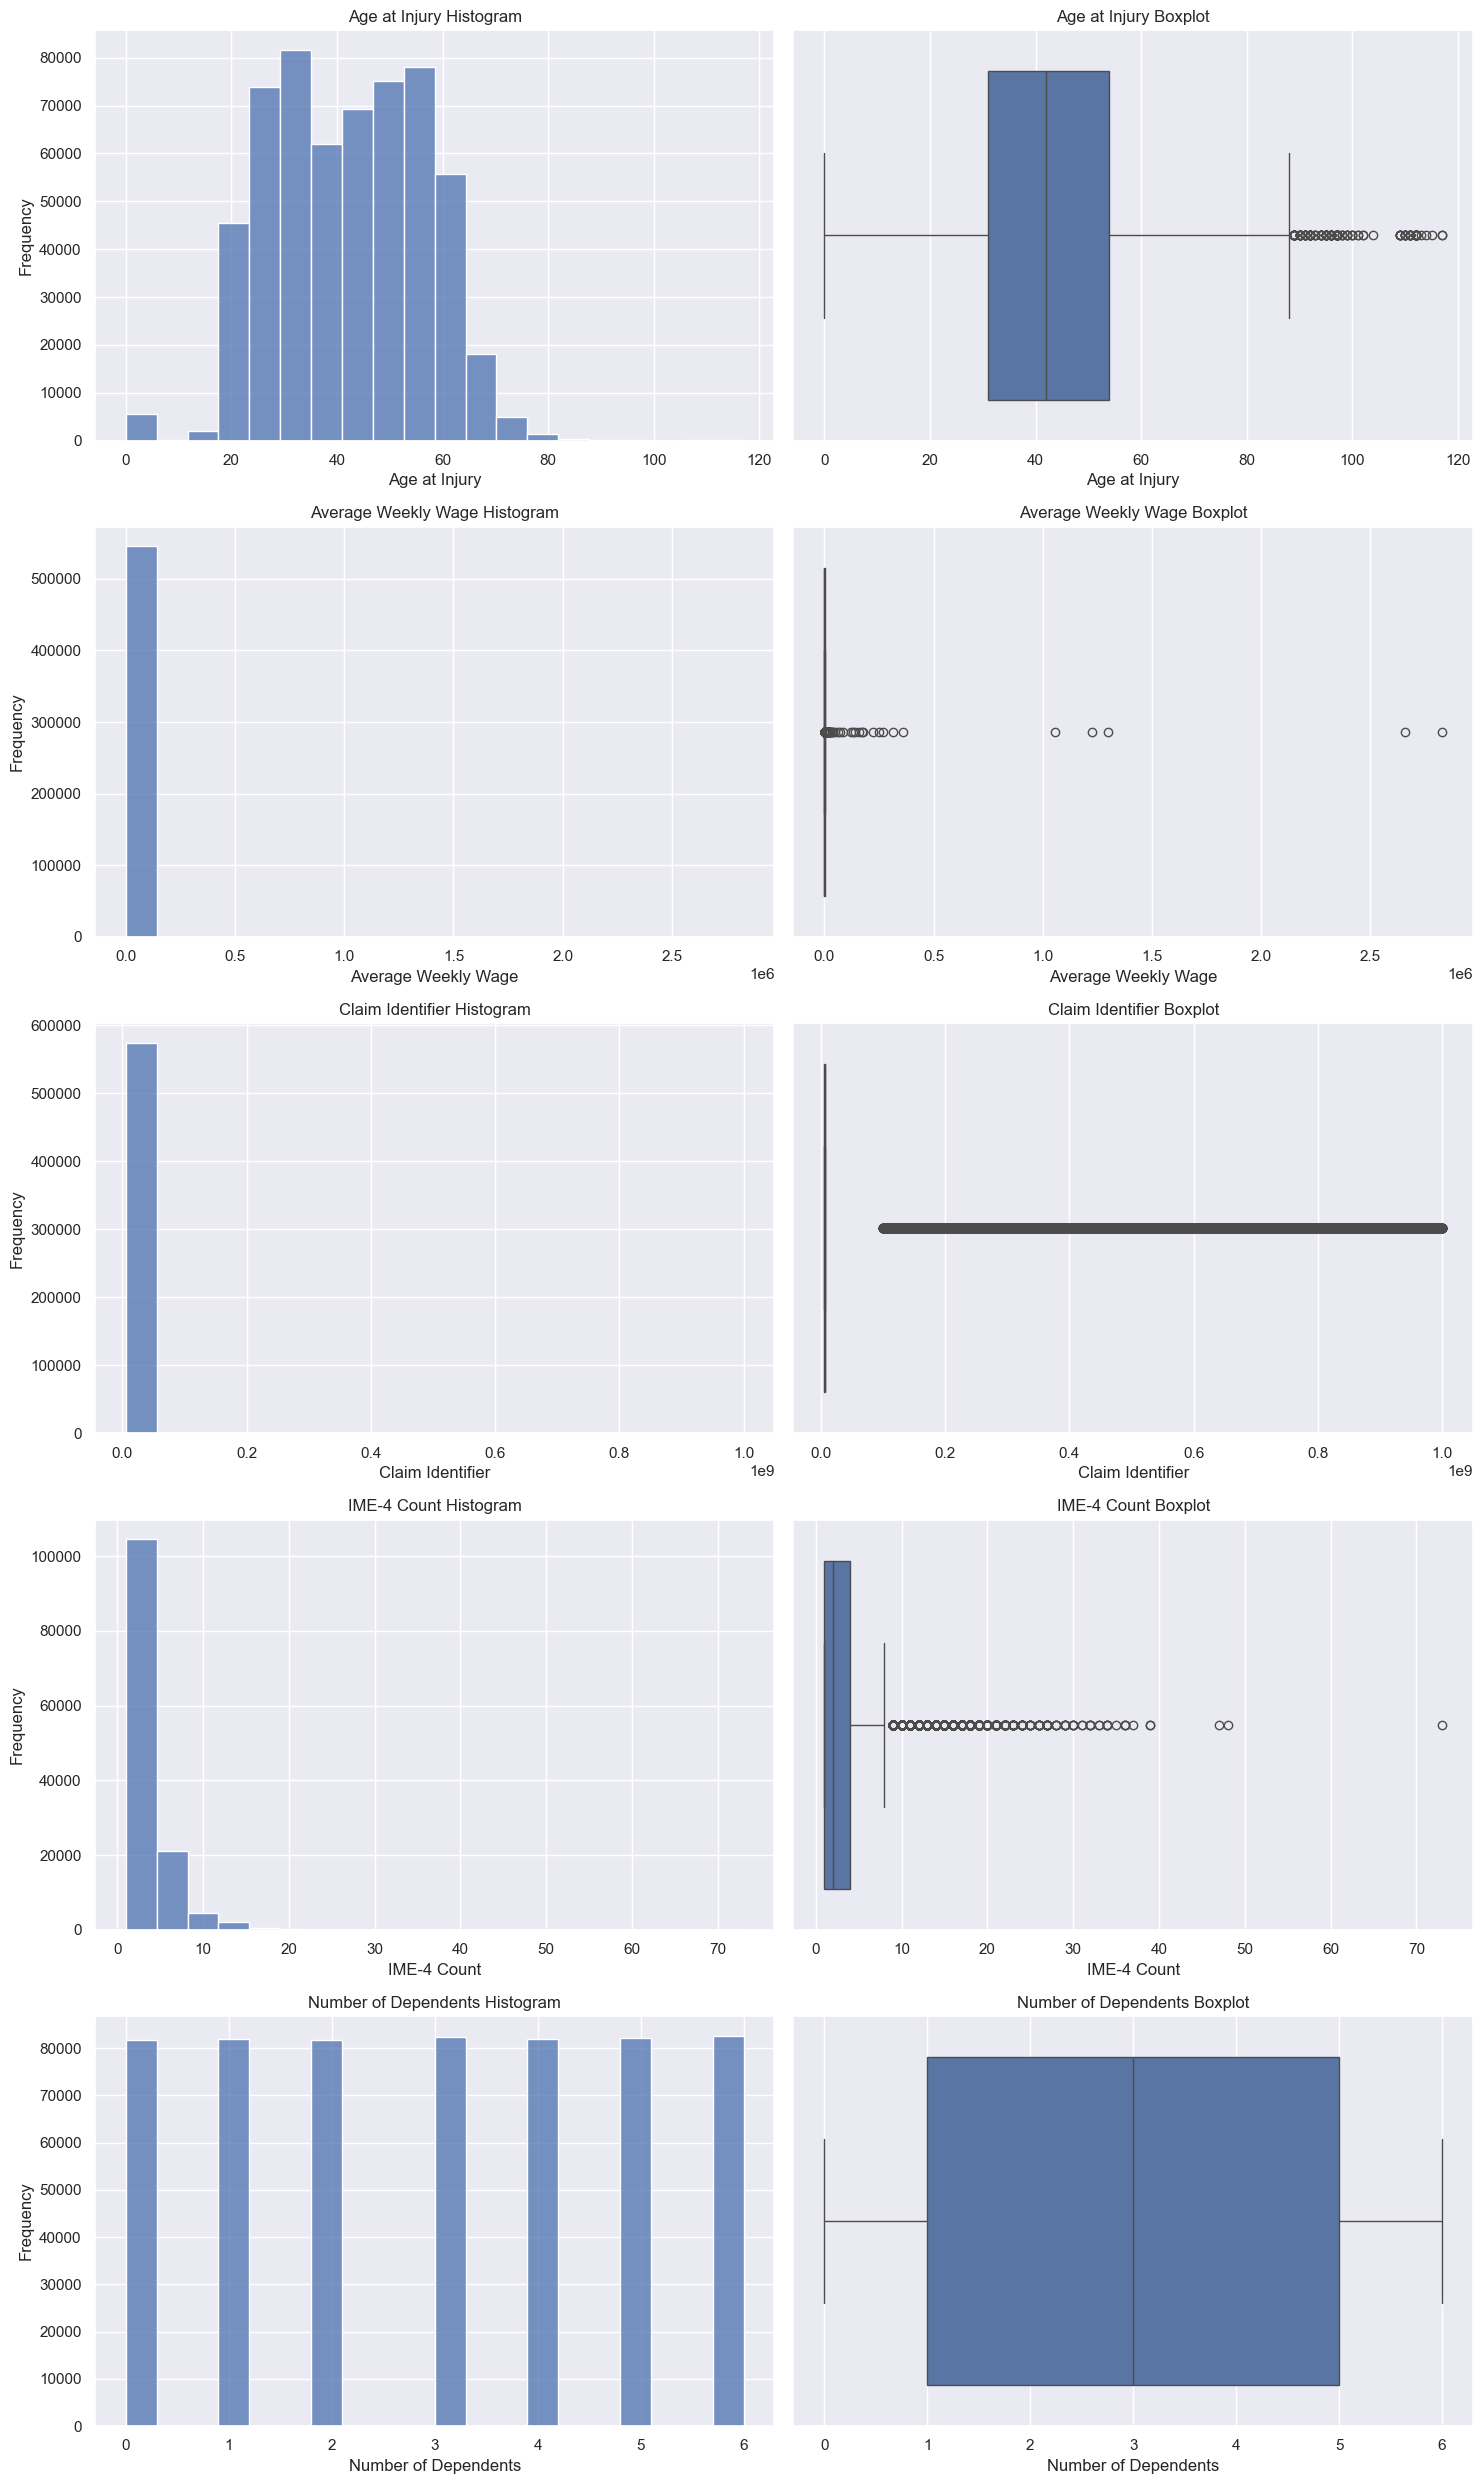

In [119]:
subset_numerical = train_df_temp[['Age at Injury', 'Average Weekly Wage', 
       'Claim Identifier', 'IME-4 Count',
       'Number of Dependents']].select_dtypes(include=[np.number])

# Create subplots for each numerical variable
n_vars = len(subset_numerical.columns)
fig, axes = plt.subplots(n_vars, 2, figsize=(15, 5*n_vars))

# Create histogram and boxplot for each variable
for i, col in enumerate(subset_numerical.columns):
    # Histogram
    sns.histplot(data=train_df_temp, x=col, bins=20, kde=False, ax=axes[i,0])
    axes[i,0].set_title(f'{col} Histogram')
    axes[i,0].set_xlabel(col)
    axes[i,0].set_ylabel('Frequency')
    
    # Boxplot
    sns.boxplot(data=train_df_temp, x=col, ax=axes[i,1])
    axes[i,1].set_title(f'{col} Boxplot')
    axes[i,1].set_xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()


1. **Age at Injury**:
   - **Histogram**: The distribution shows that most cases are clustered around ages 20–50, indicating that the majority of injuries occur in working-age adults.
   - **Boxplot**: There are some outliers above 60, suggesting that injuries among older individuals are less common but do occur.

2. **Average Weekly Wage**:
   - **Histogram**: The distribution appears highly skewed, with most data points concentrated at lower values, potentially indicating the prevalence of lower wage cases.
   - **Boxplot**: A significant number of extreme outliers, suggesting that while most wages are on the lower end, there are occasional cases with exceptionally high wages.

3. **Claim Identifier**:
   - **Histogram and Boxplot**: The distribution is highly uniform with minimal spread, indicating that this may be more of an identifier variable rather than an analytically meaningful one, so perhaps
   this variable can be droped or used as an index for each claim.

4. **IME-4 Count**:
   - **Histogram**: Shows that most cases have an IME-4 count of 0-5, with very few going beyond this range.
   - **Boxplot**: Highlights the presence of outliers, indicating that some claims have a notably higher number of IME-4 counts.

5. **Number of Dependents**:
   - **Histogram**: The distribution is fairly uniform, suggesting that the number of dependents varies widely without a clear trend.
   - **Boxplot**: A wider interquartile range indicates variability, with no significant outliers.

#### Visual Data Analysis for Categorical Features after describing them

In [120]:
categorical_cols.columns

Index(['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date',
       'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name',
       'Carrier Type', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision'],
      dtype='object')

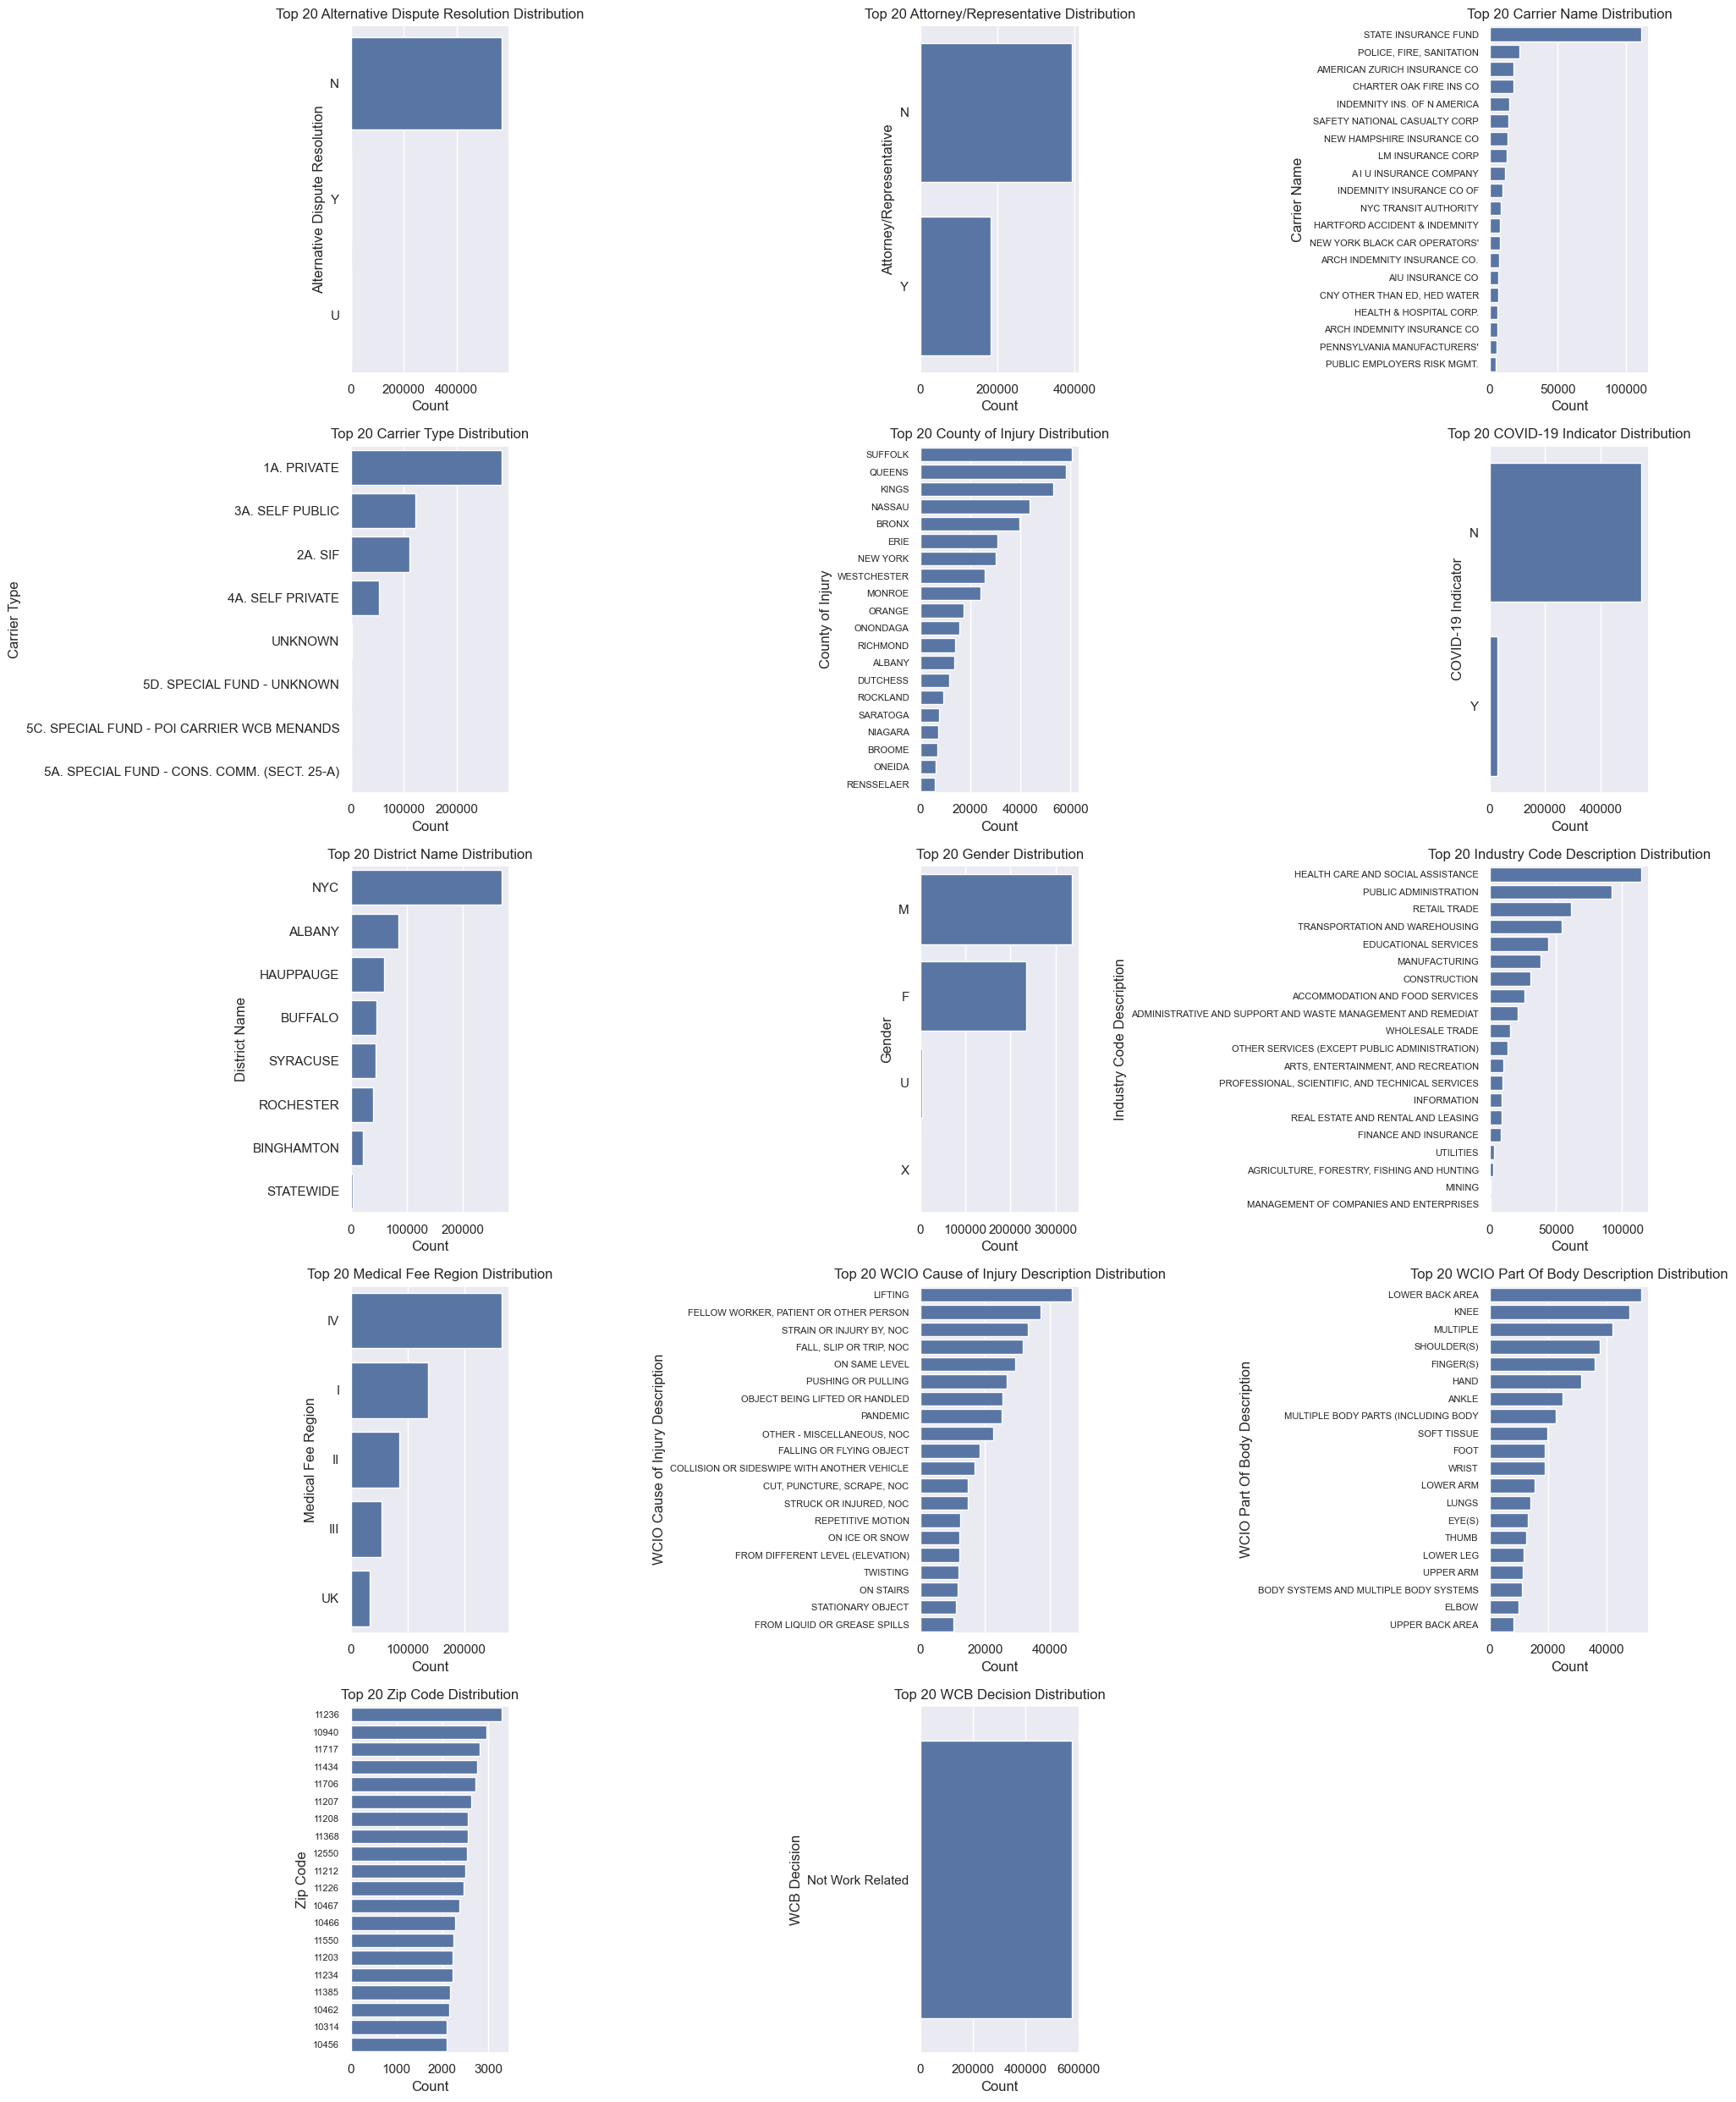

In [121]:
# Subset of categorical columns , so that we don't have dates and other features that cannot be visualized in a countplot 

subset_categorical = train_df_temp[['Alternative Dispute Resolution',
       'Attorney/Representative', 'Carrier Name',
       'Carrier Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']].select_dtypes(include=[object])

# Calculate number of rows needed (3 plots per row)
n_vars = len(subset_categorical.columns)
n_rows = (n_vars // 3) + (1 if n_vars % 3 != 0 else 0)

# Create figure
plt.figure(figsize=(20, 5 * n_rows))

# Create countplot for each variable, limiting to top 20 categories where applicable
for i, col in enumerate(subset_categorical.columns, 1):
    top_20 = train_df_temp[col].value_counts().head(20).index
    filtered_data = train_df_temp[train_df_temp[col].isin(top_20)]
    
    plt.subplot(n_rows, 3, i)
    sns.countplot(data=filtered_data, y=col, order=top_20)
    plt.title(f'Top 20 {col} Distribution')
    plt.xlabel('Count')
    
    # Adjust tick labels if too long
    if train_df_temp[col].nunique() > 10:
        plt.tick_params(axis='y', labelsize=8)

# Adjust layout
plt.tight_layout()
plt.show()



1. **Alternative Dispute Resolution & Attorney/Representative**:
   - The vast majority of cases do not involve alternative dispute resolution or attorney representation, indicating that most claims may be handled without these aspects.

2. **Carrier Name & Carrier Type**:
   - A small subset of carrier names appears frequently, suggesting a concentration of claims among a few key carriers. The distribution of carrier types is dominated by 'Private' and 'Self-Public' types, with a significant number of claims from the 'SF' and 'Unknown' types as well.

3. **County of Injury**:
   - Injuries are spread across many counties, but a few counties, like Suffolk and Nassau, have significantly higher counts, indicating regional concentrations of claims.

4. **COVID-19 Indicator**:
   - Most claims do not have a COVID-19 indicator, suggesting that COVID-19-related claims are less frequent in the dataset.

5. **District Name**:
   - The majority of claims are handled in the NYC district, with other districts like Albany and Hauppauge also showing notable counts.

6. **Gender**:
   - There is a higher count of male claimants compared to female claimants, with some cases marked as 'Unknown' or 'X'.

7. **Industry Code Description**:
   - The top industries involved in claims include health care, public administration, and construction, highlighting these sectors as more prone to work-related injuries.

8. **Medical Fee Region**:
   - Most cases fall under a few primary medical fee regions, with 'IV' and 'UK' being notably common.

9. **WCIO Cause of Injury Description**:
   - Lifting, falling, and repetitive motion are among the most common causes of injury, indicating typical work-related injuries.

10. **WCIO Part of Body Description**:
    - Injuries commonly involve the lower back, knees, and multiple parts, suggesting frequent musculoskeletal issues.

11. **Zip Code**:
    - The top 20 zip codes indicate that certain areas contribute more significantly to the dataset, possibly correlating with high population or working places areas.

12. **WCB Decision**:
    - The decision distribution shows that the majority of cases are categorized as 'Not Work Related,' which could imply a high rate of non-compensable claims or initial rejections.

## 2.3 __Data Codes to Descriptions__ Analysis and __Dropping Wrongful Codes__

__Code and Description Variables__

For the Industry Code & Industry Code Description variables, as well as for the WCIO variables, we want to check their relationship.

In [122]:
def analyze_code_description_relationship(data, code_column, description_column):
    # Step 1: Count unique descriptions per code
    code_to_description = data.groupby(code_column)[description_column].nunique()
    # Check if each code maps to a single unique description
    if code_to_description.max() == 1:
        print(f"\nEach {code_column} has only one unique {description_column}.")
    else:
        print(f"\nSome {code_column}s have multiple {description_column}s associated with them.")

    # Step 2: Count unique codes per description
    description_to_code = data.groupby(description_column)[code_column].nunique()
    # Check if each description maps to a single unique code
    if description_to_code.max() == 1:
        print(f"\nEach {description_column} has only one unique {code_column}.")
    else:
        print(f"\nSome {description_column}s have multiple {code_column}s associated with them.")

    # Step 3: Validate if there is a 1:1 relationship
    is_one_to_one = (code_to_description.max() == 1) and (description_to_code.max() == 1)
    if is_one_to_one:
        print(f"\n{code_column} and {description_column} have a 1:1 relationship.")
    else:
        print(f"\nThere is no 1:1 relationship between {code_column} and {description_column}.")

    # Step 4: Find descriptions with multiple unique associated codes
    description_to_unique_codes = data.groupby(description_column)[code_column].apply(lambda x: list(set(x)))
    descriptions_with_multiple_unique_codes = description_to_unique_codes[description_to_unique_codes.apply(len) > 1]
    
    print(f"\nDescriptions with multiple unique associated {code_column}s:")
    print(descriptions_with_multiple_unique_codes)

__Industry Code / Industry Code Description__

In [123]:
analyze_code_description_relationship(train_df_temp, 'Industry Code', 'Industry Code Description')


Each Industry Code has only one unique Industry Code Description.

Some Industry Code Descriptions have multiple Industry Codes associated with them.

There is no 1:1 relationship between Industry Code and Industry Code Description.

Descriptions with multiple unique associated Industry Codes:
Industry Code Description
MANUFACTURING                     [32.0, 33.0, 31.0]
RETAIL TRADE                            [44.0, 45.0]
TRANSPORTATION AND WAREHOUSING          [48.0, 49.0]
Name: Industry Code, dtype: object


* MANUFCTURING is associated with codes: 32, 33 and 31 

* RETRAIL TRADE is associated with codes: 44 and 45 

* TRANSPORTATION AND WAREHOUSING with codes: 48 and 49

For each __Industry Code__, the first check shows that each code corresponds to only one unique description. This indicates that every industry code maps to a single description.

Since each Industry Code uniquely maps to one Industry Code Description, we can delete the Industry Code and only keep its corresponding description. We will keep the description variable because we have more information within it that we will use for binning / mapping later. Since we have almost the same withformation in both variables, we don't need to keep both since it would distort the data for the models.

In [124]:
train_df_temp = train_df_temp.drop(columns='Industry Code')

__WCIO Cause of Injury Code / WCIO Cause of Injury Description__

In [125]:
analyze_code_description_relationship(train_df_temp, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')


Each WCIO Cause of Injury Code has only one unique WCIO Cause of Injury Description.

Some WCIO Cause of Injury Descriptions have multiple WCIO Cause of Injury Codes associated with them.

There is no 1:1 relationship between WCIO Cause of Injury Code and WCIO Cause of Injury Description.

Descriptions with multiple unique associated WCIO Cause of Injury Codes:
WCIO Cause of Injury Description
OBJECT BEING LIFTED OR HANDLED    [17.0, 66.0, 79.0]
REPETITIVE MOTION                       [97.0, 94.0]
Name: WCIO Cause of Injury Code, dtype: object


* OBJECT BEING LIFTED OR HANDLED  is associated with codes: 17, 66 and 79 

* REPETITIVE MOTION is associated with codes: 97 and 94 

For __WCIO Cause of Injury Code / Description__ it is the same as for __Industry Code / Description__. It shows that each code corresponds to only one unique description. This indicates that every code maps to a single description. However, some __WCIO Cause of Injury Descriptions__ map to more than one WCIO Cause of Injury Code. We will also just keep the __WCIO Cause of Injury Description.__

In [126]:
train_df_temp = train_df_temp.drop(columns='WCIO Cause of Injury Code')

__WCIO Nature of Injury Code / WCIO Nature of Injury Description__

In [127]:
analyze_code_description_relationship(train_df_temp, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')


Each WCIO Nature of Injury Code has only one unique WCIO Nature of Injury Description.

Each WCIO Nature of Injury Description has only one unique WCIO Nature of Injury Code.

WCIO Nature of Injury Code and WCIO Nature of Injury Description have a 1:1 relationship.

Descriptions with multiple unique associated WCIO Nature of Injury Codes:
Series([], Name: WCIO Nature of Injury Code, dtype: object)


Since the Code and the Description have a 1:1 relationship, we will delete __WCIO Nature of Injury Code__. We decided to keep the description insted of the code to later map into groups. This can be done better with the descriptions than the code because we have more information in the descriptions.

In [128]:
train_df_temp = train_df_temp.drop(columns='WCIO Nature of Injury Code')

__WCIO Part Of Body Code / WCIO Part Of Body Description__

In [129]:
analyze_code_description_relationship(train_df_temp, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')


Each WCIO Part Of Body Code has only one unique WCIO Part Of Body Description.

Some WCIO Part Of Body Descriptions have multiple WCIO Part Of Body Codes associated with them.

There is no 1:1 relationship between WCIO Part Of Body Code and WCIO Part Of Body Description.

Descriptions with multiple unique associated WCIO Part Of Body Codes:
WCIO Part Of Body Description
DISC           [43.0, 22.0]
SOFT TISSUE    [25.0, 18.0]
SPINAL CORD    [47.0, 23.0]
Name: WCIO Part Of Body Code, dtype: object


* DISC  is associated with codes: 43 and 22 

* SOFT TISSUE is associated with codes: 25 and 18

* SPINAL CORD is associated w/codes: 47 and 23

For __WCIO Part Of Body Code / Description__ it is the same as for __Industry Code / Description__ and __WCIO Cause of Injury Code / Description__. It shows that each code corresponds to only one unique description. We will also just keep the __WCIO Part Of Body Description__ for further mapping reasons.

In [130]:
train_df_temp = train_df_temp.drop(columns='WCIO Part Of Body Code')

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

The first look at the missing values reveals four insights:
1. There exist __only two__ variables __without missing values__ (Assembly Date and Claim Identifier)
2. There exists __one__ variable with __only missing values__ (OIICS Nature of Injury Description). This variable will be dropped directly.
3. There exist __three__ variables with missing values ranging from __68% - 78%__, which might be dropped.
4. Several variabes show the __same amount of missing values__ (3.28% and 5.91%)
5. Our target variable __"Claim Injury Type"__ has __19445 missing values__. The respective rows can be dropped because imputation of the target variable introduces artificial outcomes, creating bias and compromising the integrity of our model.

In [131]:
# Copy of data for preprocessing
train_df_prep = train_df_temp.copy()

# Drop the variable with only missing values
train_df_prep = train_df_prep.drop(columns='OIICS Nature of Injury Description')

In [132]:
# Drop rows where the target variable is missing
train_df_prep = train_df_prep.dropna(subset=['Claim Injury Type'])

# Check the shape of the cleaned DataFrame
print(f"Remaining rows after dropping missing target values: {len(train_df_prep)}")
print(f"Percentage of the whole training data set: {round(len(train_df_prep)/len(train_df),2)*100}%")


Remaining rows after dropping missing target values: 574026
Percentage of the whole training data set: 97.0%


In [133]:
missing_values_2 = missing_values_table(train_df_prep)

Your selected dataframe has 28 columns.
There are 11 columns that have missing values.


In [134]:
missing_values_2

,Missing Values,% of Total Values
IME-4 Count,441223,76.9
First Hearing Date,423228,73.7
C-3 Date,386781,67.4
Average Weekly Wage,28651,5.0
Zip Code,28637,5.0
WCIO Part Of Body Description,17082,3.0
WCIO Nature of Injury Description,15657,2.7
WCIO Cause of Injury Description,15640,2.7
C-2 Date,14560,2.5
Industry Code Description,9958,1.7


Nice! We can see that when dropping the rows with the missing target values, a lot of our features had the same missing values in these rows!

Let's have a look at the three variables with the high percentage of missing values:
- __IME-4 Count (77.62%)__: This variable describes the number of IME-4 forms received per claim. The missing values could be replaced with zeros, however, since the amout of missing values is so high, it's variance is relatively small.
- __First Hearing Date (74.59%)__: The description of the variable states that a blank date means the claim has not yet had a hearing held. The relationship between the date variables should be checked to determine if its relevant. Further, if the variable has an impact on the target variable, one idea would be to transform it into a binary variable which states if the first hearing date took place already (=1) or not (=0).
- __C-3 Date (68.45%)__: This variable means that the Date Form C-3 (Employee Claim Form) was received. It could also be transformed into a binary variable if it is important.

## 3.1 Imputations 

##### Dealing with Missing Values


In [135]:
# Calculate the variance of each feature (column-wise variance)
feature_variance = numeric_cols.var()

# Calculate the median of all variances (overall median of numerical feature variances)
overall_variance_median = feature_variance.median()

# Print the median of all variances
print(f"Overall Median of Variance for Numerical Features: {overall_variance_median}")

# Compare each feature variance to the overall variance median
higher_variance_features = feature_variance[feature_variance > overall_variance_median]
lower_variance_features = feature_variance[feature_variance <= overall_variance_median]

print("\nFeatures with Variance Higher than the Overall Variance Median:")
print(higher_variance_features)

print("\nFeatures with Variance Lower or Equal to the Overall Variance Median:")
print(lower_variance_features)

Overall Median of Variance for Numerical Features: 439.5337859428382

Features with Variance Higher than the Overall Variance Median:
Average Weekly Wage           3.712365e+07
Birth Year                    1.719300e+05
Claim Identifier              1.164827e+16
WCIO Cause of Injury Code     6.694784e+02
WCIO Nature of Injury Code    4.931740e+02
WCIO Part Of Body Code        5.002353e+02
dtype: float64

Features with Variance Lower or Equal to the Overall Variance Median:
Age at Injury                203.245853
IME-4 Count                    8.021942
Industry Code                385.893593
Agreement Reached              0.044488
Number of Dependents           4.003206
Claim Injury Type Numeric      1.494512
dtype: float64


In [136]:
# Calculate the Spearman correlation of each numerical feature with the target ('Claim Type Numeric')
feature_spearman_corr = numeric_cols.corrwith(train_df_prep['Claim Injury Type Numeric'], method='spearman')

# Calculate the median of all Spearman correlations (overall median of numerical feature correlations)
overall_spearman_median = feature_spearman_corr.median()

# Print the median of all Spearman correlations
print(f"Overall Median of Spearman Correlations for Numerical Features: {overall_spearman_median}")

# Compare each feature Spearman correlation to the overall Spearman median
higher_corr_features = feature_spearman_corr[feature_spearman_corr > overall_spearman_median]
lower_corr_features = feature_spearman_corr[feature_spearman_corr <= overall_spearman_median]

print("\nFeatures with Spearman Correlation Higher than the Overall Median:")
print(higher_corr_features)

print("\nFeatures with Spearman Correlation Lower or Equal to the Overall Median:")
print(lower_corr_features)

Overall Median of Spearman Correlations for Numerical Features: 0.011841023867422302

Features with Spearman Correlation Higher than the Overall Median:
Age at Injury                 0.118533
Average Weekly Wage           0.855234
Industry Code                 0.028782
WCIO Nature of Injury Code    0.023586
Agreement Reached             0.235905
Claim Injury Type Numeric     1.000000
dtype: float64

Features with Spearman Correlation Lower or Equal to the Overall Median:
Birth Year                  -0.084158
Claim Identifier            -0.058736
IME-4 Count                 -0.007009
WCIO Cause of Injury Code   -0.039392
WCIO Part Of Body Code       0.000096
Number of Dependents        -0.000625
dtype: float64


Given that IME-4 Count has 77,62% of missing values and its variance is low compared to the median variance of numerical features (8 < 439) and its spearman correlation with the target is almost 0 probably it's better if we drop this variable.

In [137]:
train_df_prep.drop(columns=['IME-4 Count'], inplace=True)

In [138]:
train_df_prep.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached',
       'WCB Decision', 'Number of Dependents', 'Claim Injury Type Numeric'],
      dtype='object')

In [139]:
# Convert columns to datetime format and handle errors
train_df_date = train_df_prep.copy()
train_df_date['Accident Date'] = pd.to_datetime(train_df_date['Accident Date'], errors='coerce')
train_df_date['Assembly Date'] = pd.to_datetime(train_df_date['Assembly Date'], errors='coerce')
train_df_date['C-2 Date'] = pd.to_datetime(train_df_date['C-2 Date'], errors='coerce')
train_df_date['C-3 Date'] = pd.to_datetime(train_df_date['C-3 Date'], errors='coerce')
train_df_date['First Hearing Date'] = pd.to_datetime(train_df_date['First Hearing Date'], errors='coerce')


# Convert columns to days 
reference_date = pd.Timestamp('2020-01-01')

# Convert datetime columns to numeric format (days since the reference date)
train_df_date['Accident Date Numeric'] = (train_df_date['Accident Date'] - reference_date).dt.days
train_df_date['Assembly Date Numeric'] = (train_df_date['Assembly Date'] - reference_date).dt.days
train_df_date['C-2 Date Numeric'] = (train_df_date['C-2 Date'] - reference_date).dt.days
train_df_date['C-3 Date Numeric'] = (train_df_date['C-3 Date'] - reference_date).dt.days
train_df_date['First Hearing Date Numeric'] = (train_df_date['First Hearing Date'] - reference_date).dt.days

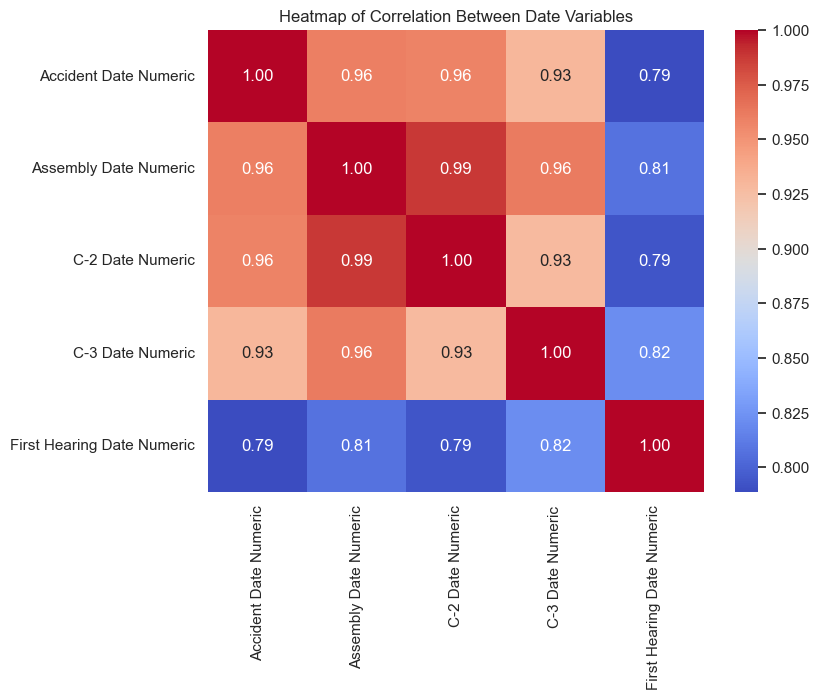

In [140]:
# Correlation matrix for date columns
correlation_matrix_date = train_df_date[['Accident Date Numeric', 'Assembly Date Numeric', 'C-2 Date Numeric', 'C-3 Date Numeric' , 'First Hearing Date Numeric']].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_date, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Heatmap of Correlation Between Date Variables')
plt.show()

* C-3 Date Numeric variable has a high correlation with other variables and 67.4% missing data, making it less informative compared to the others.

* First Hearing Date Numeric while it has the lowest correlation with the other date variables, the 73.7% missing data makes it difficult to justify its retention.

In [141]:
# Based on that we will drop Assembly Date Numeric and C-2 Date Numeric

train_df_date = train_df_date.drop(columns=['C-3 Date Numeric', 'First Hearing Date Numeric'])

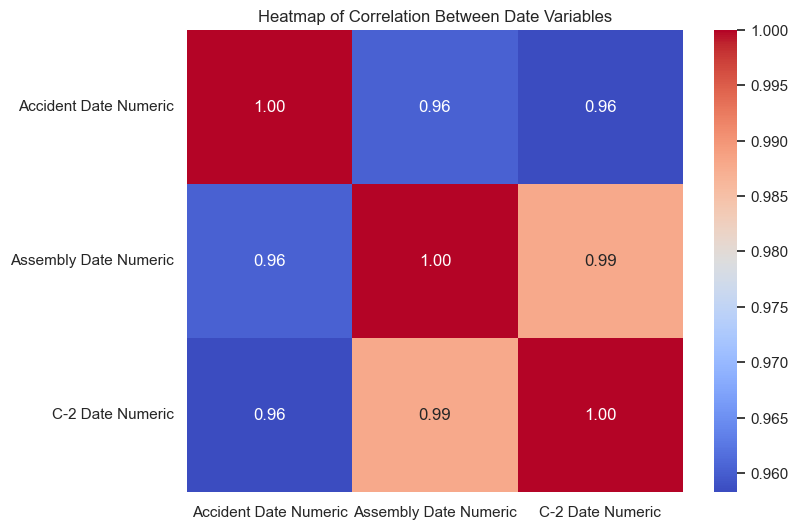

In [142]:
# Correlation matrix for date columns
correlation_matrix_date_2 = train_df_date[['Accident Date Numeric','Assembly Date Numeric' , 'C-2 Date Numeric']].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_date_2, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Heatmap of Correlation Between Date Variables')
plt.show()

In [143]:
# Calculate the correlation of each date feature with the target variable
target_correlation_2 = train_df_date[['Accident Date Numeric', 'C-2 Date Numeric','Assembly Date Numeric']].corrwith(train_df_date['Claim Injury Type Numeric'], method='spearman')

# Print the correlation results
print("Correlation with target variable:")
print(target_correlation_2) # Despite the high correlation probably the date features are not relevant for the model

Correlation with target variable:
Accident Date Numeric   -0.042228
C-2 Date Numeric        -0.046246
Assembly Date Numeric   -0.058585
dtype: float64


Despite having high correlations these variables offer different interpretations, so keep them for now is relevant. 

Since the other variables had missing values for 5% or less, let's check how many rows have no misisng values for all features.

In [144]:
# rows without missing values
rows_without_missing_values = train_df_prep.dropna()
num_rows_without_missing_values = len(rows_without_missing_values)

print(f"Number of rows without missing values: {num_rows_without_missing_values}")
print(f"% of rows without missing values: {round((num_rows_without_missing_values / len(train_df_prep)) * 100, 2)}%")

Number of rows without missing values: 96659
% of rows without missing values: 16.84%


So let's look at the other variables and how we can interpolate the missing values:

- __Average Weekly Wage__: use __median__ for missing values, since mean might be influenced by the extrem outliers we already saw; exclue wage = 0 for calculation since this seems to be some kind of mistake in the data
- __Accident Date__: drop the rows because they are only 0.6% of the remaining dataset and we can't calculate the new time features without this information. (probably droped before) 
- __C-2 Date__: Calculate average "Accident_to_C2_Lag" and compute C-2 Date by adding the amount of days to the accident day.
- __Industry Code Description__: Mode imputation, replace missing values with the most frequent category (20%)
- __WCIO Cause of Injury Description__: Mode imputation, replace missing values with the most frequent category
- __WCIO Nature of Injury Description__: Mode imputation, replace missing values with the most frequent category (27%)
- __WCIO Part Of Body Description__: Mode imputation, replace missing values with the most frequent category
- __Zip Code__: Mode imputation, replace missing values with the most frequent category


-> or randomly weighted distribution?


__Accident Date__

In [145]:
""" # Drop rows where the target variable is missing
train_df_prep = train_df_prep.dropna(subset=['Accident Date'])

# Check the shape of the cleaned DataFrame
print(f"Remaining rows after dropping missing target values: {len(train_df_prep)}")
print(f"Percentage of the whole training data set: {round(len(train_df_prep)/len(train_df),2)*100}%") """

' # Drop rows where the target variable is missing\ntrain_df_prep = train_df_prep.dropna(subset=[\'Accident Date\'])\n\n# Check the shape of the cleaned DataFrame\nprint(f"Remaining rows after dropping missing target values: {len(train_df_prep)}")\nprint(f"Percentage of the whole training data set: {round(len(train_df_prep)/len(train_df),2)*100}%") '

__C-2 Date__

In [146]:
""" # Calculate the average lag for known C-2 Dates
average_accident_to_c2_lag = train_df_date['Accident_to_C2_Lag'].mean(skipna=True)

# Fill missing C-2 Dates by adding the average lag to Accident Date
train_df_date['C-2 Date'] = train_df_date['C-2 Date'].fillna(
    train_df_date['Accident Date'] + pd.to_timedelta(average_accident_to_c2_lag, unit='D')
)

train_df_prep['C-2 Date'] = train_df_date['C-2 Date'].dt.strftime('%Y-%m-%d')

print(f"Average Accident_to_C2_Lag: {average_accident_to_c2_lag} days") """

' # Calculate the average lag for known C-2 Dates\naverage_accident_to_c2_lag = train_df_date[\'Accident_to_C2_Lag\'].mean(skipna=True)\n\n# Fill missing C-2 Dates by adding the average lag to Accident Date\ntrain_df_date[\'C-2 Date\'] = train_df_date[\'C-2 Date\'].fillna(\n    train_df_date[\'Accident Date\'] + pd.to_timedelta(average_accident_to_c2_lag, unit=\'D\')\n)\n\ntrain_df_prep[\'C-2 Date\'] = train_df_date[\'C-2 Date\'].dt.strftime(\'%Y-%m-%d\')\n\nprint(f"Average Accident_to_C2_Lag: {average_accident_to_c2_lag} days") '

In [147]:
""" train_df_prep['C-2 Date'].value_counts() """

" train_df_prep['C-2 Date'].value_counts() "

__Industry Code Description / WCIO Descriptions and Zip Code__

Before replacing the last missing values, let's check for the correlation between them.

In [148]:
from scipy.stats import chi2_contingency

# Calculates Cramér's V correlation between two categorical variables.
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    
    # Perform Chi-square test
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    
    # Calculate Cramér's V
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


In [149]:
# List of categorical columns to compare
categorical_columns = [
    'Industry Code Description',
    'WCIO Cause of Injury Description',
    'WCIO Nature of Injury Description',
    'WCIO Part Of Body Description',
    'Zip Code',
    'Claim Injury Type'
]

# Create a DataFrame to store the correlation results
correlation_cramer_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calculate pairwise Cramér's V for each combination of the variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            # Correlation with itself is always 1
            correlation_cramer_matrix.loc[col1, col2] = 1.0
        else:
            # Calculate Cramér's V for the pair
            correlation_cramer_matrix.loc[col1, col2] = cramers_v(train_df_prep[col1], train_df_prep[col2])

# Convert the results to numeric type
correlation_cramer_matrix = correlation_cramer_matrix.astype(float)


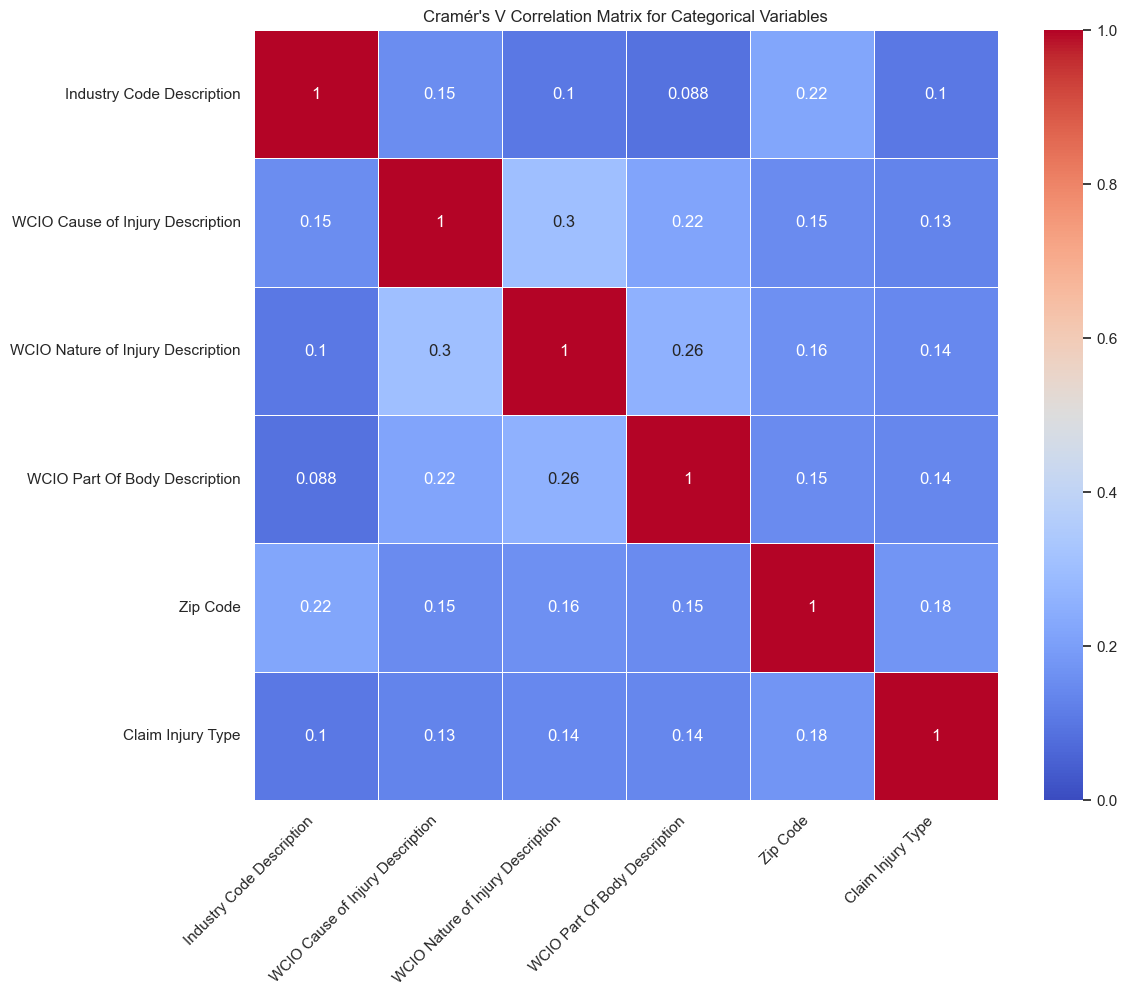

In [150]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap for the Cramér's V correlation matrix
sns.heatmap(correlation_cramer_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5)

# Set the title and labels
plt.title("Cramér's V Correlation Matrix for Categorical Variables")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()

The matrix indicates that most of the categorical variables are relatively independent of each other, with only one low association between WCIO Cause of Injury Description and WCIO Nature of Injury Description, so these features are relevant to keep.

In [151]:
# Impute missing values with mode of each column
train_df_prep_final = train_df_prep.apply(lambda col: col.fillna(col.mode()[0]))

In [152]:
# Check if all missing values are handled
missing_values_3 = missing_values_table(train_df_prep_final)

Your selected dataframe has 27 columns.
There are 0 columns that have missing values.


OR do the weighted randomly distributions for the missing values:

In [153]:
""" # Calculate the frequency distribution (weights) for the 'Industry Code' column
industry_counts = train_df_prep['Industry Code Description'].value_counts(normalize=True)

# Create a list of possible values and their corresponding weights
categories = industry_counts.index.tolist()
weights = industry_counts.values.tolist()

# Impute missing values based on the weighted distribution
# np.random.choice randomly selects from the categories based on their weights
train_df_prep['Industry Code Description'] = train_df_prep['Industry Code Description'].apply(lambda x: np.random.choice(categories, p=weights) if pd.isna(x) else x) """


" # Calculate the frequency distribution (weights) for the 'Industry Code' column\nindustry_counts = train_df_prep['Industry Code Description'].value_counts(normalize=True)\n\n# Create a list of possible values and their corresponding weights\ncategories = industry_counts.index.tolist()\nweights = industry_counts.values.tolist()\n\n# Impute missing values based on the weighted distribution\n# np.random.choice randomly selects from the categories based on their weights\ntrain_df_prep['Industry Code Description'] = train_df_prep['Industry Code Description'].apply(lambda x: np.random.choice(categories, p=weights) if pd.isna(x) else x) "

### 3.2 Outliers Handling

#### Numerical Features

#### __Age at Injury__

In [154]:
train_df_out = train_df_prep_final.copy()

In [155]:
numerical_cols.columns

Index(['Age at Injury', 'Average Weekly Wage', 'Birth Year',
       'Claim Identifier', 'IME-4 Count', 'Industry Code',
       'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Agreement Reached', 'Number of Dependents',
       'Claim Injury Type Numeric'],
      dtype='object')

Text(-0.3100000000000023, 0.5, 'Boxplot')

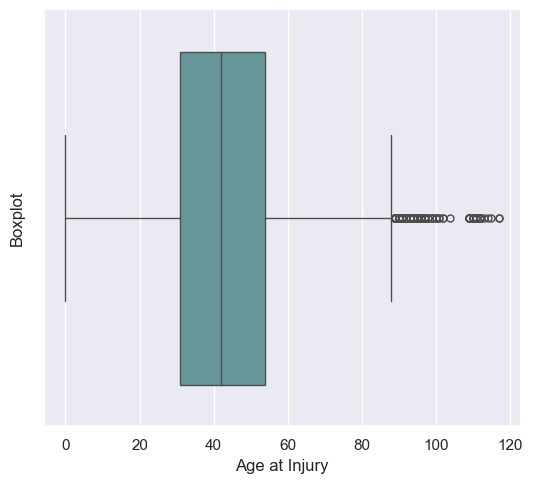

In [156]:
sns.catplot(data=train_df_out, kind='box', x='Age at Injury', color='cadetblue')
plt.xlabel('Age at Injury')
plt.ylabel('Boxplot')

# Outliers after 85 years old

In [157]:
# Total number of rows in the DataFrame
total_rows = len(train_df_out)

# Count rows with 'Age at Injury' below 14
below_14_count = train_df_out[train_df_out['Age at Injury'] < 14].shape[0]
below_14_percentage = (below_14_count / total_rows) * 100

# Count rows with 'Age at Injury' over 90
over_90_count = train_df_out[train_df_out['Age at Injury'] > 90].shape[0]
over_90_percentage = (over_90_count / total_rows) * 100

# Print the results
print(f"Number of rows with 'Age at Injury' below 14: {below_14_count} ({below_14_percentage:.2f}%)")
print(f"Number of rows with 'Age at Injury' over 90: {over_90_count} ({over_90_percentage:.2f}%)")

Number of rows with 'Age at Injury' below 14: 5511 (0.96%)
Number of rows with 'Age at Injury' over 90: 166 (0.03%)


In [158]:
# Drop rows with 'Age at Injury' below 14 or over 90
train_df_out_cleaned = train_df_out[(train_df_out['Age at Injury'] >= 14) & (train_df_out['Age at Injury'] <= 90)]

# Reset the index after dropping rows
train_df_out_cleaned.reset_index(drop=True, inplace=True)

# Print the number of rows in the cleaned DataFrame
print(f"Number of rows after removing outliers: {train_df_out_cleaned.shape[0]}")
print(f"Percentage of the whole training data set: {round(len(train_df_out_cleaned)/len(train_df),2)*100}%")

Number of rows after removing outliers: 568349
Percentage of the whole training data set: 96.0%


To deal with the outliers of "Average Weekly Wage", we will use binning such that the 0 values are one category and the high outliers will be in one category and don't bias the data too much.

#### __Average Weekly Wage__

In [159]:
# Ensuring no negative wages
train_df_out_cleaned['Average Weekly Wage'] = train_df_out_cleaned['Average Weekly Wage'].clip(lower=0)

# Calculate IQR for 'Average Weekly Wage'
Q1 = train_df_out_cleaned['Average Weekly Wage'].quantile(0.25)
Q3 = train_df_out_cleaned['Average Weekly Wage'].quantile(0.75)
IQR = Q3 - Q1

# Set thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display results
lower_bound, upper_bound, IQR

(-1200.0, 2000.0, 800.0)

In [160]:
# Check for negative values
print(train_df_out_cleaned[train_df_out_cleaned['Average Weekly Wage'] < 0])

Empty DataFrame
Columns: [Accident Date, Age at Injury, Alternative Dispute Resolution, Assembly Date, Attorney/Representative, Average Weekly Wage, C-2 Date, C-3 Date, Carrier Name, Carrier Type, Claim Identifier, Claim Injury Type, County of Injury, COVID-19 Indicator, District Name, First Hearing Date, Gender, Industry Code Description, Medical Fee Region, WCIO Cause of Injury Description, WCIO Nature of Injury Description, WCIO Part Of Body Description, Zip Code, Agreement Reached, WCB Decision, Number of Dependents, Claim Injury Type Numeric]
Index: []


In [161]:
# Filter outliers based on the adjusted bounds
outliers = train_df_out_cleaned[(train_df_out_cleaned['Average Weekly Wage'] < lower_bound) | 
                                (train_df_out_cleaned['Average Weekly Wage'] > upper_bound)]

# Display the outliers
print("Number of outliers detected:", len(outliers))

len(outliers) / len(train_df_out_cleaned)  # Percentage of outliers , which is below % so we can remove them

Number of outliers detected: 25978


0.0457078309278278

In [162]:
# Remove outliers
train_df_no_outliers = train_df_out_cleaned[(train_df_out_cleaned['Average Weekly Wage'] >= lower_bound) & 
                                             (train_df_out_cleaned['Average Weekly Wage'] <= upper_bound)]

<Axes: ylabel='Average Weekly Wage'>

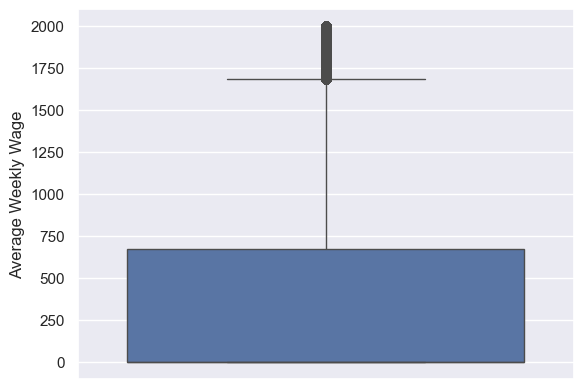

In [163]:
sns.boxplot(train_df_no_outliers['Average Weekly Wage'])

In [164]:
# Impute missing values with the median of non-zero values

# Calculate the median of non-zero values in the 'Average Weekly Wage' column
median_value = train_df_no_outliers.loc[train_df_no_outliers['Average Weekly Wage'] > 0, 'Average Weekly Wage'].median()

# Impute 0 values with the median
train_df_no_outliers['Average Weekly Wage'] = train_df_no_outliers['Average Weekly Wage'].replace(0, median_value)

# Display the updated DataFrame to confirm changes
print("Median value used for imputation:", median_value , '\n')

print("Count values after imputation:", (train_df_no_outliers['Average Weekly Wage']))

Median value used for imputation: 973.305 

Count values after imputation: 0          973.305
1         1745.930
2         1434.800
3          973.305
4          973.305
            ...   
568344     973.305
568345     973.305
568346     991.080
568347     973.305
568348     973.305
Name: Average Weekly Wage, Length: 542371, dtype: float64


In [165]:
train_df_no_outliers['Average Weekly Wage'].describe()

count    542371.000000
mean        987.929927
std         266.548682
min          13.940000
25%         973.305000
50%         973.305000
75%         973.305000
max        2000.000000
Name: Average Weekly Wage, dtype: float64

<Axes: ylabel='Average Weekly Wage'>

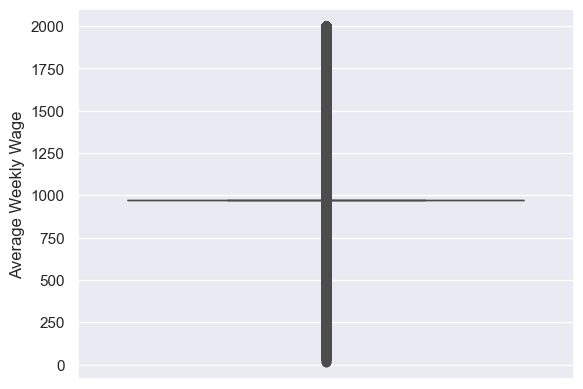

In [166]:
sns.boxplot(train_df_no_outliers['Average Weekly Wage'])

As we can see , the average weekly wage has 358755 0 values, and that's more than 50% of our data set, so imputing with the median will skew a lot the data and produce an uniform distribution.

A better approach is probably treat 0 values as a separate category to avoid skewing the data, and analyze the rest of the data, so that's what we're going to do and bin data.

__Agreement Reached__

In [167]:
train_df_out['Agreement Reached'].value_counts() 

Agreement Reached
0.0    547239
1.0     26787
Name: count, dtype: int64

We have a big class imbalance here, so we'll have to take that into consideration when modelling using for example class weighting or SMOTE technique.

__Number of Dependents__

In [168]:
dependent_counts = train_df_out['Number of Dependents'].value_counts() 

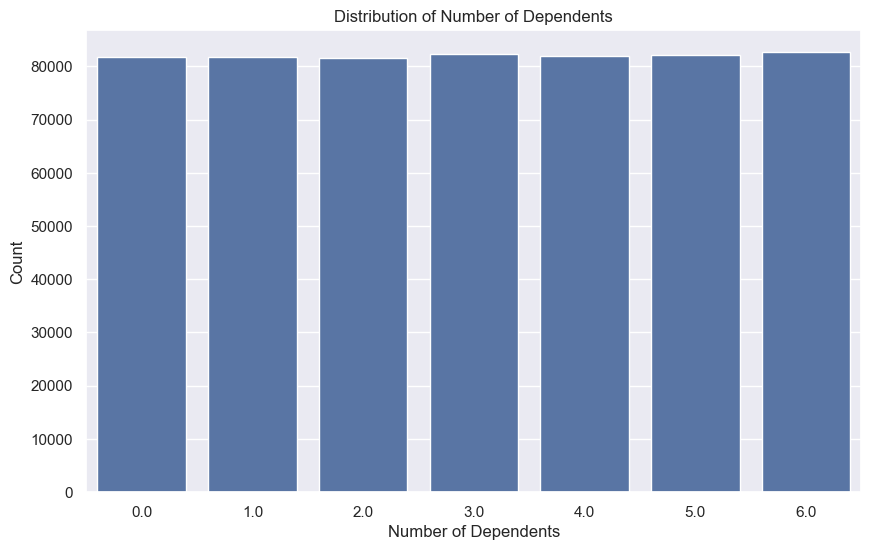

In [169]:
plt.figure(figsize=(10, 6))
sns.barplot(x=dependent_counts.index, y=dependent_counts.values)
plt.title('Distribution of Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Count')
plt.show()

The Number of Dependents variable has a discrete, uniform-like distribution across all possible values (0 to 6). Since the counts for each category are fairly balanced and there are no extreme values , outlier removal is not needed for this feature.

__Binning__:
- __Age at Injury__: Bin into 10-year age groups
- __Average Weekly Wage__: Group wages into ranges to handle the wide variance
- __Gender__: Combine "X" and "U" into an "Other" category for non-binary classifications
- __WCIO Cause of Injury Description__: Group similar injury causes together for a consolidated view of cause categories
- __WCIO Nature of Injury Description__: Group similar injury types (e.g., physical trauma, diseases) to capture broader injury classifications
- __WCIO Part Of Body Description__: Combine specific body parts into larger areas (e.g., "Upper Arm" and "Shoulder" into "Upper Arm and Shoulder") to simplify the body region analysis


In [170]:
train_df_bin = train_df_out_cleaned.copy()

In [179]:
# Group "Age at Injury" and "Average Weekly Wage" into Bins

# Define age bins and labels
age_bins = [0, 19, 29, 39, 49, 59, float('inf')]
age_labels = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60 and above']

# Create the age groups
train_df_bin['Age_Group'] = pd.cut(train_df_bin['Age at Injury'], bins=age_bins, labels=age_labels)


# Group Average Weekly Wage into bins
# Define adjusted wage bins and labels
wage_bins = [-np.inf, 1, 700, 1100, 1500, max(train_df_bin['Average Weekly Wage']) + 1]  # Use -np.inf to include 0.00
wage_labels = ['Zero', 'Below Average', 'Average', 'Above Average', 'High']

# Create the wage groups
train_df_bin['Wage_Group'] = pd.cut(train_df_bin['Average Weekly Wage'], bins=wage_bins, labels=wage_labels)

# Check the distribution of the wage groups
print(train_df_bin['Wage_Group'].value_counts())


Wage_Group
Zero             358755
High              58611
Average           56327
Below Average     52359
Above Average     42297
Name: count, dtype: int64


#### Outliers Handling 

#### __Wage Category__

In [180]:
train_df_bin['Wage_Group'].value_counts()

Wage_Group
Zero             358755
High              58611
Average           56327
Below Average     52359
Above Average     42297
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Wage_Group'>

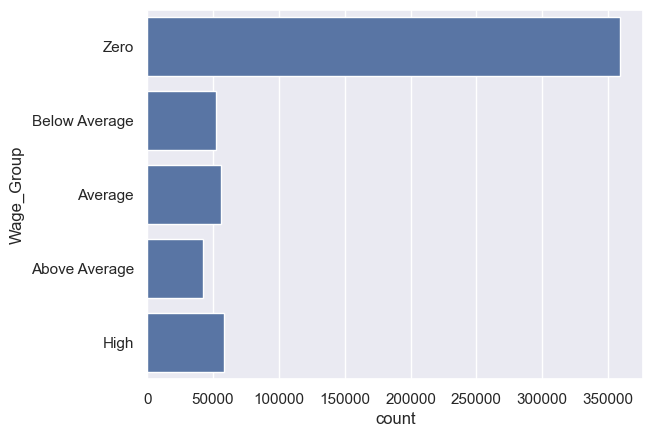

In [181]:
sns.countplot(train_df_bin['Wage_Group'])

In [ ]:
# Mapping categorical variables

# Gender: Combine "U" and "X" into "Other"
train_df_bin['Gender'] = train_df_bin['Gender'].replace({'U': 'Other', 'X': 'Other'})


In [ ]:
# WCIO Cause of Injury Description
train_df_bin['WCIO Cause of Injury Description'].unique();
train_df_bin['WCIO Cause of Injury Description'].value_counts()

WCIO Cause of Injury Description
LIFTING                                        59594
FELLOW WORKER, PATIENT OR OTHER PERSON         37094
STRAIN OR INJURY BY, NOC                       32988
FALL, SLIP OR TRIP, NOC                        31677
ON SAME LEVEL                                  29307
PUSHING OR PULLING                             26540
OBJECT BEING LIFTED OR HANDLED                 25223
PANDEMIC                                       24809
OTHER - MISCELLANEOUS, NOC                     21918
FALLING OR FLYING OBJECT                       18225
COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE    16800
CUT, PUNCTURE, SCRAPE, NOC                     14733
STRUCK OR INJURED, NOC                         14474
ON ICE OR SNOW                                 12032
FROM DIFFERENT LEVEL (ELEVATION)               11948
REPETITIVE MOTION                              11936
TWISTING                                       11866
ON STAIRS                                      11535
STATIONARY OB

In [188]:
# Mapping dictionary
injury_mapping = {
    'FALL, SLIP OR TRIP, NOC': 'Falls and Slips',
    'FROM LIQUID OR GREASE SPILLS': 'Falls and Slips',
    'ON ICE OR SNOW': 'Falls and Slips',
    'ON SAME LEVEL': 'Falls and Slips',
    'ON STAIRS': 'Falls and Slips',
    'SLIP, OR TRIP, DID NOT FALL': 'Falls and Slips',
    
    'OBJECT BEING LIFTED OR HANDLED': 'Lifting and Strain',
    'LIFTING': 'Lifting and Strain',
    'TWISTING': 'Lifting and Strain',
    'PUSHING OR PULLING': 'Lifting and Strain',
    'STRAIN OR INJURY BY, NOC': 'Lifting and Strain',
    'REACHING': 'Lifting and Strain',
    'HOLDING OR CARRYING': 'Lifting and Strain',
    
    'COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'MOTOR VEHICLE, NOC': 'Collisions and Motor Vehicle Accidents',
    'MOTOR VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'COLLISION WITH A FIXED OBJECT': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF RAIL VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF WATER VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF AIRPLANE': 'Collisions and Motor Vehicle Accidents',
    'VEHICLE UPSET': 'Collisions and Motor Vehicle Accidents',
    
    'STRUCK OR INJURED, NOC': 'Struck By Object or Person',
    'FALLING OR FLYING OBJECT': 'Struck By Object or Person',
    'STEPPING ON SHARP OBJECT': 'Struck By Object or Person',
    'FELLOW WORKER, PATIENT OR OTHER PERSON': 'Struck By Object or Person',
    'ANIMAL OR INSECT': 'Struck By Object or Person',
    'WIELDING OR THROWING': 'Struck By Object or Person',
    
    'CHEMICALS': 'Exposure to Substances and Environment',
    'DUST, GASES, FUMES OR VAPORS': 'Exposure to Substances and Environment',
    'ABSORPTION, INGESTION OR INHALATION, NOC': 'Exposure to Substances and Environment',
    'STEAM OR HOT FLUIDS': 'Exposure to Substances and Environment',
    'COLD OBJECTS OR SUBSTANCES': 'Exposure to Substances and Environment',
    'TEMPERATURE EXTREMES': 'Exposure to Substances and Environment',
    'CONTINUAL NOISE': 'Exposure to Substances and Environment',
    'MOLD': 'Exposure to Substances and Environment',
    'ABNORMAL AIR PRESSURE': 'Exposure to Substances and Environment',
    'RADIATION': 'Exposure to Substances and Environment',
    
    'HAND TOOL, UTENSIL; NOT POWERED': 'Tools, Machinery, and Objects',
    'POWERED HAND TOOL, APPLIANCE': 'Tools, Machinery, and Objects',
    'USING TOOL OR MACHINERY': 'Tools, Machinery, and Objects',
    'MOVING PARTS OF MACHINE': 'Tools, Machinery, and Objects',
    'MACHINE OR MACHINERY': 'Tools, Machinery, and Objects',
    'MOVING PART OF MACHINE': 'Tools, Machinery, and Objects',
    'OBJECT HANDLED BY OTHERS': 'Tools, Machinery, and Objects',
    'BROKEN GLASS': 'Tools, Machinery, and Objects',
    
    'FIRE OR FLAME': 'Explosions and Fire',
    'EXPLOSION OR FLARE BACK': 'Explosions and Fire',
    
    'NATURAL DISASTERS': 'Natural Disasters and Uncommon Events',
    'TERRORISM': 'Natural Disasters and Uncommon Events',
    'PANDEMIC': 'Natural Disasters and Uncommon Events',
}

# Apply mapping
train_df_bin['Injury Category'] = train_df_bin['WCIO Cause of Injury Description'].map(injury_mapping).fillna('Other')

In [189]:
train_df_bin['Injury Category'].value_counts()

Injury Category
Lifting and Strain                        168162
Other                                     131800
Falls and Slips                            99351
Struck By Object or Person                 77789
Collisions and Motor Vehicle Accidents     27860
Tools, Machinery, and Objects              27467
Natural Disasters and Uncommon Events      25376
Exposure to Substances and Environment      9914
Explosions and Fire                          630
Name: count, dtype: int64

In [184]:
# WCIO Nature of Injury Description
train_df_bin['WCIO Nature of Injury Description'].unique();
train_df_bin['WCIO Nature of Injury Description'].value_counts()

WCIO Nature of Injury Description
STRAIN OR TEAR                                                 165863
CONTUSION                                                      110483
SPRAIN OR TEAR                                                  55599
LACERATION                                                      47030
ALL OTHER SPECIFIC INJURIES, NOC                                35862
COVID-19                                                        25524
FRACTURE                                                        22639
PUNCTURE                                                        17310
MULTIPLE PHYSICAL INJURIES ONLY                                 12645
INFLAMMATION                                                    12445
BURN                                                             7499
FOREIGN BODY                                                     7363
NO PHYSICAL INJURY                                               5923
DISLOCATION                                             

In [190]:
# Mapping dictionary
injury_nature_mapping = {
    'CONTUSION': 'Physical Trauma',
    'SPRAIN OR TEAR': 'Physical Trauma',
    'CONCUSSION': 'Physical Trauma',
    'PUNCTURE': 'Physical Trauma',
    'LACERATION': 'Physical Trauma',
    'FRACTURE': 'Physical Trauma',
    'CRUSHING': 'Physical Trauma',
    'DISLOCATION': 'Physical Trauma',
    'AMPUTATION': 'Physical Trauma',
    'SEVERANCE': 'Physical Trauma',
    
    'CARPAL TUNNEL SYNDROME': 'Cumulative or Repetitive Injuries',
    'INFLAMMATION': 'Cumulative or Repetitive Injuries',
    'ALL OTHER CUMULATIVE INJURY, NOC': 'Cumulative or Repetitive Injuries',
    'ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC': 'Cumulative or Repetitive Injuries',
    'ALL OTHER SPECIFIC INJURIES, NOC': 'Cumulative or Repetitive Injuries',
    
    'BURN': 'Burns and Temperature-Related Injuries',
    'HEAT PROSTRATION': 'Burns and Temperature-Related Injuries',
    'FREEZING': 'Burns and Temperature-Related Injuries',
    
    'RESPIRATORY DISORDERS': 'Respiratory Issues',
    'ASBESTOSIS': 'Respiratory Issues',
    'DUST DISEASE, NOC': 'Respiratory Issues',
    'BLACK LUNG': 'Respiratory Issues',
    'SILICOSIS': 'Respiratory Issues',
    'BYSSINOSIS': 'Respiratory Issues',
    
    'POISONING - GENERAL (NOT OD OR CUMULATIVE': 'Poisoning and Chemical Exposure',
    'POISONING - CHEMICAL, (OTHER THAN METALS)': 'Poisoning and Chemical Exposure',
    'POISONING - METAL': 'Poisoning and Chemical Exposure',
    
    'INFECTION': 'Infections and Diseases',
    'COVID-19': 'Infections and Diseases',
    'CONTAGIOUS DISEASE': 'Infections and Diseases',
    'AIDS': 'Infections and Diseases',
    'HEPATITIS C': 'Infections and Diseases',
    'CANCER': 'Infections and Diseases',
    
    'MENTAL STRESS': 'Psychological and Mental Health',
    'MENTAL DISORDER': 'Psychological and Mental Health',
    'NO PHYSICAL INJURY': 'Psychological and Mental Health',
    'MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL': 'Psychological and Mental Health',
    
    'MYOCARDIAL INFARCTION': 'Circulatory and Heart-Related Issues',
    'ANGINA PECTORIS': 'Circulatory and Heart-Related Issues',
    'VASCULAR': 'Circulatory and Heart-Related Issues',
    
    'LOSS OF HEARING': 'Sensory Loss',
    'HEARING LOSS OR IMPAIRMENT': 'Sensory Loss',
    'VISION LOSS': 'Sensory Loss',
    'ENUCLEATION': 'Sensory Loss',
    
    'RADIATION': 'Radiation and Light Exposure',
    'VDT - RELATED DISEASES': 'Radiation and Light Exposure',
    
    # Miscellaneous (catch-all for remaining cases)
    'ASPHYXIATION': 'Miscellaneous Conditions',
    'SYNCOPE': 'Miscellaneous Conditions',
    'DERMATITIS': 'Miscellaneous Conditions',
    'ADVERSE REACTION TO A VACCINATION OR INOCULATION': 'Miscellaneous Conditions'
}

# Apply mapping
train_df_bin['Nature of Injury'] = train_df_bin['WCIO Nature of Injury Description'].map(injury_nature_mapping).fillna('Other')


In [191]:
train_df_bin['Nature of Injury'].value_counts()

Nature of Injury
Physical Trauma                           270679
Other                                     190425
Cumulative or Repetitive Injuries          55293
Infections and Diseases                    27401
Psychological and Mental Health             8280
Burns and Temperature-Related Injuries      7992
Miscellaneous Conditions                    2722
Sensory Loss                                2559
Respiratory Issues                          1477
Circulatory and Heart-Related Issues         797
Poisoning and Chemical Exposure              707
Radiation and Light Exposure                  17
Name: count, dtype: int64

In [192]:
# WCIO Part Of Body Description
train_df_bin['WCIO Part Of Body Description'].unique();
train_df_bin['WCIO Part Of Body Description'].value_counts()

WCIO Part Of Body Description
LOWER BACK AREA                                          65837
KNEE                                                     47785
MULTIPLE                                                 41836
SHOULDER(S)                                              37672
FINGER(S)                                                36044
HAND                                                     31197
ANKLE                                                    24909
MULTIPLE BODY PARTS (INCLUDING BODY                      22416
SOFT TISSUE                                              19646
FOOT                                                     18725
WRIST                                                    18625
LOWER ARM                                                15322
LUNGS                                                    13869
EYE(S)                                                   12938
THUMB                                                    12507
LOWER LEG                

In [203]:
# Mapping dictionary
body_part_mapping = {
    # Head and Face
    'SKULL': 'Head and Face', 'FACIAL BONES': 'Head and Face', 'EYE(S)': 'Head and Face',
    'MOUTH': 'Head and Face', 'NOSE': 'Head and Face', 'EAR(S)': 'Head and Face', 
    'BRAIN': 'Head and Face', 'TEETH': 'Head and Face',

    # Neck and Throat
    'MULTIPLE NECK INJURY': 'Neck and Throat', 'LARYNX': 'Neck and Throat', 'TRACHEA': 'Neck and Throat',

    # Upper and Lower Back
    'UPPER BACK AREA': 'Upper Back',
    'LOWER BACK AREA': 'Lower Back', 'LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA': 'Lower Back',
    'SACRUM AND COCCYX': 'Lower Back',

    # Spinal Column
    'SPINAL CORD': 'Spinal Column', 'VERTEBRAE': 'Spinal Column',

    # Shoulder
    'SHOULDER(S)': 'Shoulder', 

    # Arm and Wrist
    'LOWER ARM': 'Arm and Wrist', 'UPPER ARM': 'Arm and Wrist', 'WRIST': 'Arm and Wrist',

    # Hand and Fingers
    'HAND': 'Hand and Fingers', 'FINGER(S)': 'Hand and Fingers', 'THUMB': 'Hand and Fingers',

    # Hip
    'HIP': 'Hip', 

    # Leg
    'LOWER LEG': 'Leg', 'UPPER LEG': 'Leg',

    # Lower Leg and Knee
    'KNEE': 'Knee',

    # Ankle and Foot
    'ANKLE': 'Ankle and Foot', 'FOOT': 'Ankle and Foot', 'TOES': 'Ankle and Foot', 'GREAT TOE': 'Ankle and Foot',

    # Chest
    'CHEST': 'Chest',

    # Abdomen and Pelvis
    'ABDOMEN INCLUDING GROIN': 'Abdomen and Pelvis', 'PELVIS': 'Abdomen and Pelvis', 'BUTTOCKS': 'Abdomen and Pelvis',

    # Lungs
    'LUNGS': 'Lungs',

    # Heart
    'HEART': 'Heart',

    # Internal Organs
    'INTERNAL ORGANS': 'Internal Organs',

    # Body Systems
    'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS': 'Body Systems', 
    'WHOLE BODY': 'Body Systems', 'MULTIPLE BODY PARTS (INCLUDING BODY': 'Body Systems',
    'ARTIFICIAL APPLIANCE': 'Body Systems',

    # Soft Tissue
    'SOFT TISSUE': 'Soft Tissue',

    # Unclassified or Insufficient Info
    'NO PHYSICAL INJURY': 'Unclassified or Insufficient Info',
    'INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED': 'Unclassified or Insufficient Info'
}

# Apply mapping
train_df_bin['Body Part Category'] = train_df_bin['WCIO Part Of Body Description'].map(body_part_mapping).fillna('NaN')


In [200]:
train_df_bin['Body Part Category'].value_counts()

Body Part Category
Hand and Fingers                     79748
NaN                                  71509
Lower Back                           68226
Ankle and Foot                       47970
Knee                                 47785
Arm and Wrist                        45163
Shoulder                             37672
Body Systems                         34587
Head and Face                        34521
Soft Tissue                          19646
Leg                                  15893
Lungs                                13869
Unclassified or Insufficient Info    11283
Abdomen and Pelvis                    8649
Upper Back                            8218
Chest                                 7629
Hip                                   6394
Internal Organs                       3704
Neck and Throat                       3060
Spinal Column                         2196
Heart                                  627
Name: count, dtype: int64

In [208]:
# District Name
train_df_bin['District Name'].unique();
train_df_bin['District Name'].value_counts()

District Name
NYC           267787
ALBANY         85478
HAUPPAUGE      59900
BUFFALO        45114
SYRACUSE       44324
ROCHESTER      40178
BINGHAMTON     21726
STATEWIDE       3842
Name: count, dtype: int64

In [210]:
train_df_bin['Medical Fee Region'].unique();
train_df_bin['Medical Fee Region'].value_counts()

Medical Fee Region
IV     263159
I      134848
II      84341
III     53127
UK      32874
Name: count, dtype: int64

In [211]:
train_df_bin['County of Injury'].unique();
train_df_bin['County of Injury'].value_counts()

County of Injury
SUFFOLK         59784
QUEENS          57660
KINGS           52600
NASSAU          43136
BRONX           39226
ERIE            30577
NEW YORK        29625
WESTCHESTER     25464
MONROE          23919
ORANGE          17295
ONONDAGA        15411
RICHMOND        13801
ALBANY          13550
DUTCHESS        11433
ROCKLAND         9026
SARATOGA         7457
NIAGARA          7139
BROOME           6679
ONEIDA           6194
RENSSELAER       5864
ULSTER           5205
CAYUGA           4512
HERKIMER         4375
ONTARIO          4034
CHAUTAUQUA       4029
CHEMUNG          3798
OSWEGO           3711
FULTON           3549
PUTNAM           3432
ST. LAWRENCE     3329
JEFFERSON        3216
CLINTON          3034
CATTARAUGUS      2906
SULLIVAN         2849
GENESEE          2710
COLUMBIA         2565
MADISON          2426
WARREN           2256
LIVINGSTON       2101
DELAWARE         1866
WASHINGTON       1798
GREENE           1741
ALLEGANY         1726
WAYNE            1603
CHENANGO       

Zip Code is the location where employee and thus it shouldn't have impact , because he can work in a different location than where he lives and the location of the injury is what matters, so zip code can be dropped.

In [255]:
train_df_bin['Carrier Type'].unique();
train_df_bin['Carrier Type'].value_counts()

Carrier Type
1A. PRIVATE                                    282435
3A. SELF PUBLIC                                120571
2A. SIF                                        110375
4A. SELF PRIVATE                                52375
UNKNOWN                                          1623
5D. SPECIAL FUND - UNKNOWN                        964
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)         3
5C. SPECIAL FUND - POI CARRIER WCB MENANDS          3
Name: count, dtype: int64

In [257]:
train_df_bin['Attorney/Representative'].unique();
train_df_bin['Attorney/Representative'].value_counts()

Attorney/Representative
N    390090
Y    178259
Name: count, dtype: int64

#### Carrier Name

In [258]:
train_df_bin['Carrier Name'].unique();
train_df_bin['Carrier Name'].value_counts()

Carrier Name
STATE INSURANCE FUND            110375
POLICE, FIRE, SANITATION         21396
AMERICAN ZURICH INSURANCE CO     17363
CHARTER OAK FIRE INS CO          17032
INDEMNITY INS. OF N AMERICA      14245
                                 ...  
ROCKWOOD CASUALTY INS. CO.           1
UNIGARD INSURANCE COMPANY            1
FIRST CENTRAL INS CO                 1
BRADFORD CENTRAL SCHOOL DIST         1
HERMON-DEKALB CENTRAL                1
Name: count, Length: 2035, dtype: int64

In [273]:
threshold = 5000  # Define a threshold for frequency
carrier_counts = train_df_bin['Carrier Name'].value_counts()
train_df_bin['Carrier Name Grouped'] = train_df_bin['Carrier Name'].apply(
    lambda x: x if carrier_counts[x] > threshold else 'Other'
)


In [274]:
train_df_bin['Carrier Name Grouped'].value_counts()

Carrier Name Grouped
Other                            276514
STATE INSURANCE FUND             110375
POLICE, FIRE, SANITATION          21396
AMERICAN ZURICH INSURANCE CO      17363
CHARTER OAK FIRE INS CO           17032
INDEMNITY INS. OF N AMERICA       14245
SAFETY NATIONAL CASUALTY CORP     13837
NEW HAMPSHIRE INSURANCE CO        12653
LM INSURANCE CORP                 12153
A I U INSURANCE COMPANY           10925
INDEMNITY INSURANCE CO OF          9029
NYC TRANSIT AUTHORITY              7831
HARTFORD ACCIDENT & INDEMNITY      7482
NEW YORK BLACK CAR OPERATORS'      7301
ARCH INDEMNITY INSURANCE CO.       6621
AIU INSURANCE CO                   6423
CNY OTHER THAN ED, HED WATER       6269
HEALTH & HOSPITAL CORP.            5560
ARCH INDEMNITY INSURANCE CO        5340
Name: count, dtype: int64

In [276]:
train_df_bin['Alternative Dispute Resolution'].unique();
train_df_bin['Alternative Dispute Resolution'].value_counts() # Big class imbalance

Alternative Dispute Resolution
N    565757
Y      2587
U         5
Name: count, dtype: int64

In [281]:
from sklearn.feature_selection import mutual_info_classif

# Encode the categorical 'Alternative Dispute Resolution' column if not already numerical
train_df_bin['Alternative Dispute Resolution Encoded'] = train_df_bin['Alternative Dispute Resolution'].map({'N': 0, 'Y': 1, 'U': 2})

# Calculate mutual information
mutual_info = mutual_info_classif(train_df_bin[['Alternative Dispute Resolution Encoded']], train_df_bin['Claim Injury Type Numeric'], discrete_features=True)

# Display the result
print("Mutual Information between 'Alternative Dispute Resolution' and target:")
print(mutual_info[0])

Mutual Information between 'Alternative Dispute Resolution' and target:
0.003031349417433052


In [283]:
train_df_bin.drop(columns='Alternative Dispute Resolution', inplace=True)

In [ ]:
train_df_bin['WCB Decision'].unique();
train_df_bin['WCB Decision'].value_counts() # 1 value only so we should drop it

WCB Decision
Not Work Related    568349
Name: count, dtype: int64

In [278]:
train_df_bin.drop(columns='WCB Decision', inplace=True)

__Feature Extraction:__
- __Lag_Time__: Difference in days between accident date and assembly date
- __Accident_to_C2_Lag__: Difference in days between accident date and C-2 date

In [201]:
# Convert columns to datetime format and handle errors
train_df_date2 = train_df_bin.copy()
train_df_date2['Accident Date'] = pd.to_datetime(train_df_date2['Accident Date'], errors='coerce')
train_df_date2['Assembly Date'] = pd.to_datetime(train_df_date2['Assembly Date'], errors='coerce')
train_df_date2['C-2 Date'] = pd.to_datetime(train_df_date2['C-2 Date'], errors='coerce')

# Check for any correlation between date columns by converting them to numeric values (days since start)
train_df_date2['Lag_Time'] = (train_df_date2['Assembly Date'] - train_df_date2['Accident Date'].min()).dt.days
train_df_date2['Accident_to_C2_Lag'] = (train_df_date2['C-2 Date'] - train_df_date2['Accident Date'].min()).dt.days

# Correlation matrix for date columns
correlation_matrix_date = train_df_date2[['Lag_Time', 'Accident_to_C2_Lag']].corr()
correlation_matrix_date

,Lag_Time,Accident_to_C2_Lag
Lag_Time,1.000000,0.765352
Accident_to_C2_Lag,0.765352,1.000000


In [202]:
train_df_bin['Lag_Time'] = train_df_date2['Lag_Time']
train_df_bin['Accident_to_C2_Lag'] = train_df_date2['Accident_to_C2_Lag']

### 3.4 Data Scaling

## 4. Feature Selection <a id='features'></a>
[to the top](#top)

_"Define and implement an unambiguous strategy for feature selection. Use methods discussed in the course. Present and justify your final selection."_

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_

In [ ]:
# test